In [ ]:
!pip install yfinance tensorflow ta gym textblob

In [ ]:
!pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Conv1D, LSTM, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import datetime
import ta
import gym
from gym import spaces
from sklearn.preprocessing import StandardScaler
import warnings
from tensorflow.keras.layers import GlobalAveragePooling1D
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE=1000000
# total number of stocks in our portfolio
STOCK_DIM = 10
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001

In [ ]:
class PositionTracker:
    """Tracks average cost basis for stock positions"""
    def __init__(self):
        self.total_shares = 0
        self.total_cost = 0

    def add_purchase(self, shares, price):
        """Add shares to position"""
        self.total_shares += shares
        self.total_cost += shares * price

    def reduce_position(self, shares):
        """Remove shares from position"""
        self.total_shares = max(0, self.total_shares - shares)

    def get_avg_cost(self):
        """Get average cost per share"""
        return self.total_cost / self.total_shares if self.total_shares > 0 else 0

In [ ]:
class MultiStockTradingEnv(gym.Env):
    """
    Trading environment that handles multiple stocks simultaneously
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, stock_dfs, initial_balance=1000000, transaction_fee_percent=0.0001,
                window_size=20):
        super(MultiStockTradingEnv, self).__init__()

        self.stock_dfs = stock_dfs  # Dictionary of dataframes {symbol: dataframe}
        self.symbols = list(stock_dfs.keys())
        self.n_stocks = len(self.symbols)
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.transaction_fee_percent = transaction_fee_percent

        # Find common dates across all stocks
        common_dates = None
        for symbol, df in stock_dfs.items():
            if common_dates is None:
                common_dates = set(df.index)
            else:
                common_dates = common_dates.intersection(set(df.index))

        self.common_dates = sorted(list(common_dates))
        print(f"Trading environment created with {len(self.common_dates)} common trading days")

        # Action space: For each stock: [no action, buy 25%, buy 50%, buy 75%, buy 100%, sell 25%, sell 50%, sell 75%, sell 100%]
        # Plus one action for rebalancing the portfolio
        self.action_space = spaces.Discrete(self.n_stocks * 9 + 1)

        # Observation space: window_size of data for each stock + portfolio state
        self.feature_count = len(next(iter(stock_dfs.values())).columns)  # Features per stock
        portfolio_features = 2 + self.n_stocks  # Cash + total value + allocation per stock

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.window_size, self.n_stocks * self.feature_count + portfolio_features),
            dtype=np.float32
        )

        self.position_cost = {symbol: PositionTracker() for symbol in self.symbols}
        self.win_rate = 0.5       # Initial win probability
        self.win_loss_ratio = 1   # Initial win/loss ratio

        # Initialize episode variables
        self.reset()

    def reset(self):
        """Reset the environment to the initial state"""
        # Reset portfolio
        self.portfolio = {symbol: 0 for symbol in self.symbols}
        self.balance = self.initial_balance

        # Find common dates across all stocks if not already defined
        if not hasattr(self, 'common_dates'):
            # Find common dates across all stocks
            self.common_dates = sorted(set.intersection(
                *[set(df.index) for df in self.stock_dfs.values()]
            ))
            if not self.common_dates:
                raise ValueError("No common dates found across stocks")

        # Reset current step
        self.window_size = min(self.window_size, len(self.common_dates) - 1)  # Safety check
        self.current_date_idx = self.window_size

        # Set current date based on index
        if 0 <= self.current_date_idx < len(self.common_dates):
            self.current_date = self.common_dates[self.current_date_idx]
        else:
            # Fallback if index is invalid
            self.current_date = self.common_dates[0] if self.common_dates else None
            self.current_date_idx = 0

        print(f"Reset environment: current_date_idx={self.current_date_idx}, current_date={self.current_date}")

        # Reset tracking variables
        self.portfolio_value_history = [self.initial_balance]
        self.trade_history = {symbol: [] for symbol in self.symbols}

        # Reset episode state
        self.done = False  # Initialize done flag

        # Calculate initial portfolio value
        try:
            stock_value = self._calculate_stocks_value()
            self.portfolio_value = self.balance + stock_value
        except Exception as e:
            print(f"Error calculating portfolio value during reset: {e}")
            self.portfolio_value = self.balance

        self.portfolio_value_history.append(self.portfolio_value)

        # Get initial observation
        try:
            observation = self._get_observation()
        except Exception as e:
            print(f"Error getting observation during reset: {e}")
            # Create a placeholder observation if there's an error
            observation = np.zeros((self.window_size, len(self.symbols) * 5 + 2))

        return observation

    def step(self, action):
        """Take an action in the environment using multi-stock logic"""
        # Check if the episode is already marked as done
        if self.done:
            # Return the last valid observation or a zero observation if called after done
            last_observation = self._get_observation() if hasattr(self, 'current_date') else np.zeros(self.observation_space.shape, dtype=np.float32)
            print("Warning: step() called after episode finished. Returning last state.")
            return last_observation, 0, True, {"portfolio_value": self.portfolio_value}

        # Initialize sentiment_debug_info at the beginning of the method
        sentiment_debug_info = {'available': False}  # Default value

        # Store previous portfolio value for reward calculation
        prev_portfolio_value = self.portfolio_value
        total_transaction_cost = 0  # Initialize cost for this step

        # Execute action and get trade reward/cost
        try:
            trade_reward, transaction_cost = self._take_action(action)
            total_transaction_cost += transaction_cost
        except Exception as e:
            print(f"Error during _take_action for action {action}: {e}")
            trade_reward = -10  # Penalize if action execution fails
            transaction_cost = 0
            total_transaction_cost = 0

        # Move to the next date index
        self.current_date_idx += 1

        # Check if the episode has ended AFTER incrementing the index
        self.done = self.current_date_idx >= len(self.common_dates)

        # Initialize variables for this scope
        new_portfolio_value = self.portfolio_value  # Default to previous value if done
        next_observation = None

        if not self.done:
            # Update current date ONLY if not done
            try:
                self.current_date = self.common_dates[self.current_date_idx]
            except IndexError:
                print(f"Error: current_date_idx {self.current_date_idx} is out of bounds for common_dates (len: {len(self.common_dates)}). Ending episode.")
                self.done = True
                # Use the last valid date from the list for final calculations if possible
                self.current_date = self.common_dates[-1] if self.common_dates else None

            # Calculate new portfolio value AFTER updating date and executing trades
            try:
                # Ensure current_date is valid before calculating value
                if self.current_date:
                    new_portfolio_value = self.balance + self._calculate_stocks_value()
                    self.portfolio_value = new_portfolio_value  # Update the main portfolio value attribute
                    self.portfolio_value_history.append(new_portfolio_value)
                else:
                    # If date is invalid, keep previous value
                    new_portfolio_value = prev_portfolio_value
            except Exception as e:
                print(f"Error calculating portfolio value on {self.current_date}: {e}. Using previous value.")
                new_portfolio_value = prev_portfolio_value  # Revert to previous value on error

            # Get the next observation based on the NEW date
            try:
                # Ensure current_date is valid before getting observation
                if self.current_date:
                    next_observation = self._get_observation()
                else:
                    # If date is invalid, return zero observation and end
                    next_observation = np.zeros(self.observation_space.shape, dtype=np.float32)
                    self.done = True
            except Exception as e:
                print(f"Error getting observation on {self.current_date}: {e}. Returning zero observation.")
                next_observation = np.zeros(self.observation_space.shape, dtype=np.float32)
                self.done = True  # Consider ending episode if observation fails

        else:
            # If done at the start of the step (or became done due to index increment)
            # Use the last calculated portfolio value
            new_portfolio_value = self.portfolio_value
            # Create a final zero observation as the terminal state representation
            next_observation = np.zeros(self.observation_space.shape, dtype=np.float32)

        # ================== Enhanced Normalized Reward Calculation ==================
        # Initialize raw reward components
        raw_components = {
            'portfolio_change': 0,
            'sharpe_ratio': 0,
            'drawdown': 0,
            'sentiment_alignment': 0
        }

        # Calculate raw components
        # 1. Portfolio Value Change
        if prev_portfolio_value > 0:
            portfolio_change = (new_portfolio_value / prev_portfolio_value) - 1
            raw_components['portfolio_change'] = portfolio_change * 100  # Convert to percentage

        # 2. Sharpe Ratio
        if len(self.portfolio_value_history) > 30:
            returns = np.diff(np.log(self.portfolio_value_history[-30:]))
            if len(returns) > 1 and np.std(returns) > 1e-9:
                sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Annualized
                raw_components['sharpe_ratio'] = sharpe

        # 3. Drawdown
        if len(self.portfolio_value_history) > 1:
            peak = np.max(self.portfolio_value_history)
            if peak > 0:
                current_drawdown = (peak - new_portfolio_value) / peak
                raw_components['drawdown'] = current_drawdown * 100  # Convert to percentage

        # 4. Sentiment Alignment
        if hasattr(self, 'sentiment_scores') and action < self.n_stocks * 9:
            stock_idx = action // 9
            action_type = action % 9
            symbol = self.symbols[stock_idx]

            if symbol in self.sentiment_scores:
                try:
                    # Get current sentiment for this stock
                    if self.current_date in self.sentiment_scores[symbol].index:
                        current_sentiment = self.sentiment_scores[symbol].loc[self.current_date]

                        # Update sentiment_debug_info
                        sentiment_debug_info = {
                            'available': True,
                            'symbol': symbol,
                            'sentiment': float(current_sentiment),
                            'action_type': int(action_type)
                        }
                        # Calculate volatility adjustment factor
                        volatility_factor = 0.5  # Default value
                        try:
                            if self.current_date_idx > 20:
                                recent_prices = []
                                for i in range(max(0, self.current_date_idx-20), self.current_date_idx+1):
                                    if i < len(self.common_dates):
                                        date = self.common_dates[i]
                                        if date in self.stock_dfs[symbol].index:
                                            recent_prices.append(self.stock_dfs[symbol].loc[date]['Close'])

                                if len(recent_prices) > 5:
                                    volatility = np.std(recent_prices) / np.mean(recent_prices)
                                    volatility_factor = 1 / (1 + 5 * volatility)  # Reduce impact in volatile periods
                        except Exception as e:
                            print(f"Error calculating volatility for {symbol}: {e}")

                        # Determine if action aligns with sentiment
                        if action_type == 0:  # No action
                            alignment = 0  # Neutral for no action
                        elif (1 <= action_type <= 4 and current_sentiment > 0):  # Buy on positive
                            alignment = current_sentiment * volatility_factor
                        elif (5 <= action_type <= 8 and current_sentiment < 0):  # Sell on negative
                            alignment = -current_sentiment * volatility_factor
                        else:  # Misaligned action
                            alignment = -0.1 * volatility_factor  # Reduced penalty

                        raw_components['sentiment_alignment'] = alignment * 5  # Scale for normalization
                except (KeyError, TypeError) as e:
                    print(f"Error processing sentiment for {symbol}: {e}")

        # Normalize each component to [-1, 1] range
        normalized_components = {}

        # Define normalization parameters (based on typical ranges)
        norm_params = {
            'portfolio_change': {'min': -5, 'max': 5},     # Daily returns typically within ±5%
            'sharpe_ratio': {'min': -3, 'max': 3},         # Typical Sharpe ratio range
            'drawdown': {'min': 0, 'max': 20},             # Drawdowns from 0-20%
            'sentiment_alignment': {'min': -1, 'max': 1}   # Sentiment scores typically normalized
        }

        # Apply normalization to each component
        for component, value in raw_components.items():
            min_val = norm_params[component]['min']
            max_val = norm_params[component]['max']

            # Handle drawdown specially (convert to penalty)
            if component == 'drawdown':
                # Normalize and negate (higher drawdown = more negative reward)
                normalized_val = -np.clip((value - min_val) / (max_val - min_val) * 2 - 1, -1, 1)
            else:
                # Standard min-max normalization to [-1, 1]
                normalized_val = np.clip((value - min_val) / (max_val - min_val) * 2 - 1, -1, 1)

            normalized_components[component] = normalized_val

        # Calculate weighted normalized reward
        total_reward = (
            0.45 * normalized_components.get('portfolio_change', 0) +
            0.2 * normalized_components.get('sharpe_ratio', 0) +
            0.2 * normalized_components.get('drawdown', 0) +
            0.15 * normalized_components.get('sentiment_alignment', 0)
        )

        # Store both raw and normalized components for debugging
        reward_components = {
            'raw': {k: float(v) for k, v in raw_components.items()},
            'normalized': {k: float(v) for k, v in normalized_components.items()}
        }

        # Prepare info dictionary
        info = {
            "portfolio_value": new_portfolio_value,
            "balance": self.balance,
            "holdings": {s: self.portfolio.get(s, 0) for s in self.symbols},
            "date": self.current_date if not self.done and self.current_date else self.common_dates[-1] if self.common_dates else None,
            "reward_components": reward_components,
            "sentiment_debug_info": sentiment_debug_info
        }

        # Print reward components periodically
        if self.current_date_idx % 50 == 1:
            print(f"--- Step {self.current_date_idx} ({self.current_date}) ---")
            print(f"Raw Components: {', '.join([f'{k}: {v:.4f}' for k, v in raw_components.items()])}")
            print(f"Normalized: {', '.join([f'{k}: {v:.4f}' for k, v in normalized_components.items()])}")
            print(f"Total Reward: {total_reward:.4f}")
            print(f"Portfolio Value: {new_portfolio_value:.2f}")

            # Print sentiment info if available
            if sentiment_debug_info['available']:
                print(f"Symbol: {sentiment_debug_info['symbol']}, Date: {self.current_date}, "
                      f"Sentiment: {sentiment_debug_info['sentiment']}, Action: {sentiment_debug_info['action_type']}")
                if 'is_proxy' in sentiment_debug_info and sentiment_debug_info['is_proxy']:
                    print("(Using price momentum as sentiment proxy)")
            else:
                print("No sentiment alignment calculation performed for this step")

            print(f"-------------------------------------")

        return next_observation, total_reward, self.done, info


    # ===== END of Replacement =====

    def _calculate_stocks_value(self):
        """Calculate the current value of all stocks in the portfolio"""
        if not hasattr(self, 'current_date') or self.current_date is None:
            print("Warning: current_date not set in _calculate_stocks_value")
            return 0

        total_value = 0
        try:
            for symbol, shares in self.portfolio.items():
                if shares > 0:
                    price = self.stock_dfs[symbol].loc[self.current_date]['Close']
                    total_value += shares * price
        except KeyError as e:
            print(f"Error in _calculate_stocks_value: Date {self.current_date} not found. {e}")
            # Try using the most recent date available
            try:
                available_dates = self.stock_dfs[list(self.portfolio.keys())[0]].index
                closest_date = available_dates[available_dates <= pd.to_datetime(self.current_date)][-1]
                print(f"Using closest available date: {closest_date}")

                for symbol, shares in self.portfolio.items():
                    if shares > 0:
                        price = self.stock_dfs[symbol].loc[closest_date]['Close']
                        total_value += shares * price
            except Exception as nested_e:
                print(f"Fallback also failed: {nested_e}")
        except Exception as e:
            print(f"Unexpected error in _calculate_stocks_value: {e}")

        return total_value

    def _get_observation(self):
        """
        Create observation by combining data from all stocks and portfolio state
        """
        # Get window of data for each stock
        stock_data = []

        for symbol in self.symbols:
            df = self.stock_dfs[symbol]
            # Get dates in the current window
            window_dates = self.common_dates[self.current_date_idx-self.window_size:self.current_date_idx]
            # Get data for those dates
            window_data = df.loc[window_dates].values
            stock_data.append(window_data)

        # Combine all stock data
        combined_stock_data = np.hstack(stock_data)
        print(f"Combined stock data shape: {combined_stock_data.shape}")

        # Calculate portfolio information
        total_value = self.balance + self._calculate_stocks_value()

        # Calculate allocation percentages
        allocations = []
        for symbol in self.symbols:
            shares = self.portfolio[symbol]
            price = self.stock_dfs[symbol].loc[self.current_date]['Close']
            stock_value = shares * price
            allocation = stock_value / total_value if total_value > 0 else 0
            allocations.append(allocation)

        # Create portfolio state information for each time step in the window
        portfolio_info = np.zeros((self.window_size, 2 + self.n_stocks))
        portfolio_info[:, 0] = self.balance / self.initial_balance  # Cash ratio
        portfolio_info[:, 1] = total_value / self.initial_balance  # Total value ratio
        portfolio_info[:, 2:] = allocations  # Stock allocations

        # Combine stock data with portfolio information
        observation = np.hstack((combined_stock_data, portfolio_info))

        if observation.ndim == 2 and observation.shape[0] == self.window_size:
             # Apply standardization feature-wise (column-wise)
             mean = np.mean(observation, axis=0, keepdims=True)
             std = np.std(observation, axis=0, keepdims=True)
             # Add small epsilon to prevent division by zero
             observation = (observation - mean) / (std + 1e-8)
             # Replace any potential NaNs resulting from zero std dev columns
             observation = np.nan_to_num(observation)
        else:
             print(f"Warning: Observation shape {observation.shape} not as expected for normalization.")
        # --- END NORMALIZATION ---

        return observation

    def _calculate_kelly_position(self):
        """Calculate position size using Kelly Criterion"""
        if self.win_rate == 0 or self.win_loss_ratio == 0:
            return 0.1  # Default to 10% position
        return self.win_rate - (1 - self.win_rate)/self.win_loss_ratio

    def _update_position_cost(self, symbol, price, shares):
        """Track average cost basis for each position"""
        if symbol not in self.position_cost:
            self.position_cost[symbol] = PositionTracker()

        if shares > 0:  # Buying
            self.position_cost[symbol].add_purchase(shares, price)
        else:  # Selling
            self.position_cost[symbol].reduce_position(-shares)

    def _take_action(self, action):
        """Execute trade action with position sizing and dynamic rewards"""
        # Initialize variables with default values
        reward = 0
        transaction_cost = 0
        symbol = None  # Initialize symbol for safety in error cases
        last_action_index = self.n_stocks * 9
        if int(action) == last_action_index:
            # This is the "+1" action, e.g., rebalance or hold all
            # Implement desired behavior here. For now, let's treat it as Hold All.
            print(f"Info: Action {action} interpreted as Hold All.")
            try:
                # Call the rebalance portfolio method and get the reward
                rebalance_reward = self._rebalance_portfolio()
                # Return the reward from rebalancing and 0 for transaction cost
                # (transaction costs are handled inside _rebalance_portfolio)
                return rebalance_reward, 0
            except Exception as e:
                print(f"Error during portfolio rebalancing: {e}")
                import traceback
                traceback.print_exc()
                return -5, 0
        try:
            # --- Action Interpretation and Symbol Determination FIRST ---
            action_type = int(action) % 9  # Ensure action is integer; 0-8 actions per stock
            stock_idx = int(action) // 9

            # Validate stock index before accessing self.symbols
            if not (0 <= stock_idx < len(self.symbols)):
                print(f"Warning: Invalid stock index {stock_idx} derived from action {action}. Taking no action.")
                return 0, 0 # Return neutral reward and zero cost

            symbol = self.symbols[stock_idx] # Assign symbol based on index
            # --- END Interpretation ---

            # --- Get Current Price AFTER symbol is known ---
            try:
                current_price = self.stock_dfs[symbol].loc[self.current_date]['Close']
            except KeyError:
                # ... (Error handling for price fetch remains the same) ...
                print(f"Warning: Date {self.current_date} not found for {symbol}. Using previous day's close or skipping action.")
                try:
                    current_date_dt = pd.to_datetime(self.current_date)
                    date_index = self.common_dates.index(current_date_dt)
                    prev_idx = date_index - 1
                    if prev_idx >= 0:
                        prev_date = self.common_dates[prev_idx]
                        current_price = self.stock_dfs[symbol].loc[prev_date]['Close']
                        print(f"Using price from {prev_date}: {current_price}")
                    else:
                        print(f"Cannot get previous price for {symbol} on {self.current_date}.")
                        return 0, 0
                except (ValueError, IndexError, KeyError, AttributeError) as fallback_e:
                    print(f"Fallback price retrieval failed for {symbol} on {self.current_date}: {fallback_e}")
                    return 0, 0

            # --- Now proceed with action logic ---
            portfolio_value = self.balance + self._calculate_stocks_value()
            max_pos_size_attr = getattr(self, 'max_position_size', 0.3)
            #kelly_fraction = min(self._calculate_kelly_position(), 0.5)

            # --- Handle Action Type ---
            if action_type == 0: # No action
                 # ... (Holding penalty/reward logic remains the same) ...
                 holding_reward_penalty = 0
                 if symbol in self.portfolio and self.portfolio[symbol] > 0 and symbol in self.position_cost:
                     avg_cost = self.position_cost[symbol].get_avg_cost()
                     if avg_cost > 0:
                         current_pnl_pct = (current_price - avg_cost) / avg_cost
                         if current_pnl_pct < -0.02:
                             holding_reward_penalty = current_pnl_pct * 10
                         elif current_pnl_pct > 0.01:
                             holding_reward_penalty = 0.1
                 return holding_reward_penalty, 0

            # Buy actions (1-4)
            elif 1 <= action_type <= 4:
                buy_percentage = action_type * 0.25

                # --- MODIFIED Risk Capital Calculation ---
                # Use a simpler approach: Risk a fixed fraction (e.g., 2-5%) of portfolio per trade, adjusted by buy_percentage
                base_risk_fraction = 0.05 # Example: Risk up to 5% of portfolio value on a 100% buy action
                potential_risk_capital = portfolio_value * base_risk_fraction
                # Ensure risk capital doesn't exceed half the portfolio or the available balance
                risk_capital = min(potential_risk_capital, portfolio_value * 0.5, self.balance)
                # --- END MODIFICATION ---

                amount_to_buy_value_step1 = min(risk_capital * buy_percentage, self.balance)

                current_stock_value = self.portfolio.get(symbol, 0) * current_price
                max_value_for_this_stock = portfolio_value * max_pos_size_attr
                allowed_additional_value = max(0, max_value_for_this_stock - current_stock_value)

                amount_to_buy_value = min(amount_to_buy_value_step1, allowed_additional_value)
                if amount_to_buy_value <= 1.0:
                    return -0.5 * buy_percentage, 0 # Return the penalty

                # ... (rest of the buy execution logic) ...
                shares_bought = amount_to_buy_value / current_price
                cost = amount_to_buy_value * (1 + self.transaction_fee_percent)

                if cost > self.balance:
                     return -0.5 * buy_percentage, 0

                self.balance -= cost
                self.portfolio[symbol] = self.portfolio.get(symbol, 0) + shares_bought
                transaction_cost = amount_to_buy_value * self.transaction_fee_percent
                self._update_position_cost(symbol, current_price, shares_bought)
                reward = 0.5 * buy_percentage

            # Sell actions (5-8)
            elif 5 <= action_type <= 8:
                # ... (Sell logic remains the same) ...
                sell_percentage = (action_type - 4) * 0.25
                shares_owned = self.portfolio.get(symbol, 0)
                shares_to_sell = shares_owned * sell_percentage

                if shares_to_sell <= 1e-6:
                    return -0.5 * sell_percentage, 0

                sale_value = shares_to_sell * current_price
                proceeds = sale_value * (1 - self.transaction_fee_percent)

                self.balance += proceeds
                self.portfolio[symbol] -= shares_to_sell
                transaction_cost = sale_value * self.transaction_fee_percent

                avg_cost = self.position_cost[symbol].get_avg_cost()
                if avg_cost > 0:
                    price_change_pct = (current_price - avg_cost) / avg_cost
                    reward = price_change_pct * sell_percentage * 100
                else:
                    reward = 0

                self._update_position_cost(symbol, current_price, -shares_to_sell)


            final_reward = reward
            final_reward = np.clip(final_reward, -25, 25)

            return final_reward, transaction_cost

        # ... (Error handling blocks remain the same) ...
        except IndexError as e:
            print(f"Error interpreting action {action} (IndexError): {e}. Symbol: {symbol}")
            return -5, 0
        except KeyError as e:
             print(f"Error accessing data for {symbol if symbol else 'Unknown Symbol'} on date {self.current_date} (KeyError): {e}")
             return -5, 0
        except Exception as e:
            symbol_str = symbol if symbol else "Unknown Symbol (error occurred before assignment)"
            print(f"Unexpected error executing action {action} for {symbol_str}: {e}")
            import traceback
            traceback.print_exc()
            return -10, 0

# ===== END of Modification =====


    def _rebalance_portfolio(self):
    # Calculate total portfolio value
      total_value = self.balance + self._calculate_stocks_value()

    # Target allocation per stock
      target_allocation = 1.0 / (self.n_stocks + 1)  # +1 for cash
      target_stock_value = total_value * target_allocation
      target_cash = target_stock_value

      reward = 0

    # First sell overweight positions
      for symbol in self.symbols:
        current_price = self.stock_dfs[symbol].loc[self.current_date]['Close']
        current_shares = self.portfolio[symbol]
        current_value = current_price * current_shares

        if current_value > target_stock_value:
            # Overweight position, need to sell
            value_to_sell = current_value - target_stock_value
            shares_to_sell = value_to_sell / current_price

            if shares_to_sell > 0:
                sell_value = shares_to_sell * current_price
                transaction_cost = sell_value * self.transaction_fee_percent

                # Execute sell
                self.balance += (sell_value - transaction_cost)
                self.portfolio[symbol] -= shares_to_sell

                self.trade_history[symbol].append({
                    'date': self.current_date,
                    'type': 'rebalance_sell',
                    'shares': shares_to_sell,
                    'price': current_price,
                    'cost': transaction_cost,
                    'proceeds': sell_value - transaction_cost
                })

                reward += 0.5

    # Then buy underweight positions
      for symbol in self.symbols:
        current_price = self.stock_dfs[symbol].loc[self.current_date]['Close']
        current_shares = self.portfolio[symbol]
        current_value = current_price * current_shares

        if current_value < target_stock_value and self.balance > 0:
            # Underweight position, need to buy
            value_to_buy = min(target_stock_value - current_value, self.balance)

            if value_to_buy > 0:
                shares_to_buy = value_to_buy / current_price
                transaction_cost = value_to_buy * self.transaction_fee_percent

                if value_to_buy + transaction_cost > self.balance:
                    value_to_buy = self.balance / (1 + self.transaction_fee_percent)
                    shares_to_buy = value_to_buy / current_price
                    transaction_cost = value_to_buy * self.transaction_fee_percent

                # Execute buy
                self.balance -= (value_to_buy + transaction_cost)
                self.portfolio[symbol] += shares_to_buy

                self.trade_history[symbol].append({
                    'date': self.current_date,
                    'type': 'rebalance_buy',
                    'shares': shares_to_buy,
                    'price': current_price,
                    'cost': value_to_buy + transaction_cost
                })

                reward += 0.5

      return reward

    def render(self, mode='human'):
      if mode != 'human':
        return

    # Calculate portfolio value history
      portfolio_values = np.array(self.portfolio_value_history)

    # Calculate returns
      if len(portfolio_values) > 1:
        returns = (portfolio_values[-1] / portfolio_values[0] - 1) * 100
        print(f"Portfolio value: ${portfolio_values[-1]:.2f}")
        print(f"Total return: {returns:.2f}%")

        # Plot portfolio value over time
        plt.figure(figsize=(12, 6))
        plt.plot(portfolio_values)
        plt.title('Portfolio Value Over Time')
        plt.xlabel('Trading Days')
        plt.ylabel('Portfolio Value ($)')
        plt.grid(True)
        plt.show()

        # Plot allocation over time if available
        if hasattr(self, 'allocation_history') and len(self.allocation_history) > 0:
            allocations = pd.DataFrame(self.allocation_history)

            plt.figure(figsize=(12, 6))
            allocations.plot(kind='area', figsize=(12, 6), stacked=True)
            plt.title('Portfolio Allocation Over Time')
            plt.xlabel('Trading Days')
            plt.ylabel('Allocation (%)')
            plt.grid(True)
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
            plt.tight_layout()
            plt.show()

In [ ]:
class RiskManager:
    """
    Risk management module for controlling position sizes and managing risk
    """
    def __init__(self, max_position_size=0.2, stop_loss_pct=0.2,
                 max_drawdown=0.15, volatility_lookback=20):
        self.max_position_size = max_position_size  # Maximum allocation to a single stock (0.2 = 20%)
        self.stop_loss_pct = stop_loss_pct  # Stop loss percentage (5%)
        self.max_drawdown = max_drawdown  # Maximum allowed drawdown
        self.volatility_lookback = volatility_lookback  # Days to calculate volatility

    def calculate_position_size(self, portfolio_value, price_history, symbol):
        """
        Calculate the optimal position size based on volatility
        Uses the Average True Range (ATR) for position sizing
        """
        if len(price_history) < self.volatility_lookback:
            return self.max_position_size  # Default if not enough history

        # Calculate ATR
        highs = price_history['High'].values[-self.volatility_lookback:]
        lows = price_history['Low'].values[-self.volatility_lookback:]
        closes = price_history['Close'].values[-self.volatility_lookback:-1]  # Previous closes

        tr1 = highs - lows
        tr2 = np.abs(highs - np.append([closes[0]], closes))
        tr3 = np.abs(lows - np.append([closes[0]], closes))

        true_ranges = np.vstack([tr1, tr2, tr3]).max(axis=0)
        atr = true_ranges.mean()

        # Adjust position size inversely to volatility
        current_price = price_history['Close'].values[-1]
        volatility = atr / current_price  # Normalized ATR

        # More volatile = smaller position size
        position_size = self.max_position_size * (0.05 / max(volatility, 0.005))

        # Cap at maximum position size
        return min(position_size, self.max_position_size)

    def check_stop_loss(self, entry_price, current_price, position_type='long'):
        """
        Check if stop loss has been triggered
        """
        if position_type == 'long':
            return current_price < entry_price * (1 - self.stop_loss_pct)
        else:  # short position
            return current_price > entry_price * (1 + self.stop_loss_pct)

    def check_drawdown(self, peak_value, current_value):
        """
        Check if maximum drawdown has been exceeded
        """
        if peak_value == 0:
            return False

        drawdown = (peak_value - current_value) / peak_value
        return drawdown > self.max_drawdown

    def kelly_position_size(self, win_rate, win_loss_ratio, max_risk=0.02):
        """
        Calculate position size using Kelly Criterion
        f* = (p*b - q) / b where:
        - p = win probability
        - q = loss probability (1-p)
        - b = win/loss ratio
        """
        if win_rate <= 0 or win_loss_ratio <= 0:
            return 0

        kelly = win_rate - (1 - win_rate) / win_loss_ratio

        # Fractional Kelly (usually safer)
        half_kelly = kelly * 0.5

        # Cap at maximum risk
        return min(half_kelly, max_risk)

    def integrate_with_trading_env(self, env, stock_dfs):
        """
        Integrate risk management with the trading environment
        """
        class RiskManagedTradingEnv(env.__class__):
            def __init__(self_env, *args, **kwargs):
                super(RiskManagedTradingEnv, self_env).__init__(*args, **kwargs)
                self_env.risk_manager = self
                self_env.position_entry_prices = {symbol: 0 for symbol in self_env.symbols}
                self_env.peak_portfolio_value = self_env.initial_balance
                self_env.trailing_win_rate = 0.5  # Start with neutral win rate
                self_env.win_count = 0
                self_env.loss_count = 0
                self_env.win_amount = 0
                self_env.loss_amount = 0

            def _take_action(self_env, action):
                prev_portfolio_value = self_env.portfolio_value

                # Check for stop losses first
                for symbol, shares in self_env.portfolio.items():
                    if shares > 0:
                        entry_price = self_env.position_entry_prices[symbol]
                        current_price = self_env.stock_dfs[symbol].loc[self_env.current_date]['Close']

                        if entry_price > 0 and self.check_stop_loss(entry_price, current_price):
                            # Sell position due to stop loss
                            proceeds = shares * current_price * (1 - self_env.transaction_fee_percent)
                            self_env.balance += proceeds
                            self_env.portfolio[symbol] = 0
                            self_env.trade_history[symbol].append(
                                ('STOP_LOSS', self_env.current_date, shares, current_price)
                            )

                # Check for maximum drawdown
                current_value = self_env.balance + self_env._calculate_stocks_value()
                if current_value > self_env.peak_portfolio_value:
                    self_env.peak_portfolio_value = current_value

                if self.check_drawdown(self_env.peak_portfolio_value, current_value):
                    # Sell everything due to exceeding max drawdown
                    for symbol, shares in self_env.portfolio.items():
                        if shares > 0:
                            current_price = self_env.stock_dfs[symbol].loc[self_env.current_date]['Close']
                            proceeds = shares * current_price * (1 - self_env.transaction_fee_percent)
                            self_env.balance += proceeds
                            self_env.portfolio[symbol] = 0
                            self_env.trade_history[symbol].append(
                                ('MAX_DRAWDOWN', self_env.current_date, shares, current_price)
                            )
                    return -0.1  # Penalty for hitting max drawdown

                # Normal action processing with position sizing
                result = super(RiskManagedTradingEnv, self_env)._take_action(action)

                # Update win/loss statistics for Kelly criterion
                new_value = self_env.balance + self_env._calculate_stocks_value()
                if new_value != prev_portfolio_value:  # If a trade was made
                    if new_value > prev_portfolio_value:
                        self_env.win_count += 1
                        self_env.win_amount += (new_value - prev_portfolio_value)
                    else:
                        self_env.loss_count += 1
                        self_env.loss_amount += (prev_portfolio_value - new_value)

                    # Update trailing win rate
                    trade_count = self_env.win_count + self_env.loss_count
                    if trade_count > 0:
                        self_env.trailing_win_rate = self_env.win_count / trade_count

                        # Calculate win/loss ratio for Kelly
                        avg_win = self_env.win_amount / max(self_env.win_count, 1)
                        avg_loss = self_env.loss_amount / max(self_env.loss_count, 1)
                        win_loss_ratio = avg_win / max(avg_loss, 1)

                        # Store for later use
                        self_env.kelly_factor = self.kelly_position_size(
                            self_env.trailing_win_rate, win_loss_ratio
                        )

                return result

            def get_position_size(self_env, symbol, portfolio_value):
                """
                Get optimal position size for a particular stock
                """
                price_history = self_env.stock_dfs[symbol].loc[:self_env.current_date].tail(30)
                base_size = self.calculate_position_size(portfolio_value, price_history, symbol)

                # Adjust by Kelly criterion if available
                if hasattr(self_env, 'kelly_factor'):
                    return min(base_size, self_env.kelly_factor)
                return base_size

        # Create instance of the risk-managed environment
        risk_env = RiskManagedTradingEnv(stock_dfs=stock_dfs)
        return risk_env

In [ ]:
import nltk
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import datetime as dt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Download NLTK resources
try:
    nltk.download('vader_lexicon', quiet=True)
    nltk.download('punkt', quiet=True)
except:
    print("NLTK download failed. Internet connection required for first-time setup.")

class NewsSentimentAnalyzer:
    """
    Analyze news sentiment for stock market prediction
    """
    def __init__(self, use_transformers=True):
        self.use_transformers = use_transformers

        # Initialize VADER sentiment analyzer as fallback
        self.vader = SentimentIntensityAnalyzer()

        if use_transformers:
            try:
                print("Loading FinBERT model for sentiment analysis...")
                self.tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
                self.model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
                print("FinBERT model loaded successfully.")
            except Exception as e:
                print(f"Failed to load FinBERT model: {e}. Falling back to VADER.")
                self.use_transformers = False

        # Initialize news cache to avoid repeated API calls
        self.news_cache = {}

    def clean_text(self, text):
        """Clean and preprocess text"""
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def get_sentiment_vader(self, text):
        """Get sentiment score using VADER"""
        sentiment = self.vader.polarity_scores(text)
        return sentiment['compound']  # Range: -1 (negative) to 1 (positive)

    def get_sentiment_finbert(self, text):
        """Get sentiment score using FinBERT"""
        try:
            # Ensure text is not too long for the model
            max_length = 512
            if len(text) > max_length:
                text = text[:max_length]

            inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():  # No need to track gradients for inference
                outputs = self.model(**inputs)

            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

            # FinBERT classes: negative (0), neutral (1), positive (2)
            negative_score = probabilities[0][0].item()
            neutral_score = probabilities[0][1].item()
            positive_score = probabilities[0][2].item()

            # Normalize to [-1, 1] range
            score = positive_score - negative_score

            return score
        except Exception as e:
            print(f"FinBERT error: {e}")
            return self.get_sentiment_vader(text)  # Fallback to VADER

    def get_sentiment(self, text):
        """Get sentiment score using selected method"""
        text = self.clean_text(text)
        if self.use_transformers:
            return self.get_sentiment_finbert(text)
        else:
            return self.get_sentiment_vader(text)

    def fetch_news_yahoo(self, ticker, days_back=3):
        """Fetch news from Yahoo Finance with caching"""
        # Check cache first
        cache_key = f"{ticker}_{days_back}_{datetime.now().strftime('%Y-%m-%d')}"
        if cache_key in self.news_cache:
            return self.news_cache[cache_key]

        news_data = []
        try:
            # Yahoo Finance URL
            url = f"https://finance.yahoo.com/quote/{ticker}/news"
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

            response = requests.get(url, headers=headers, timeout=10)
            soup = BeautifulSoup(response.text, 'html.parser')

            # Extract news items
            news_items = soup.find_all('div', {'class': 'Ov(h) Pend(44px) Pstart(25px)'})

            for item in news_items:
                try:
                    headline = item.find('h3').text
                    timestamp = item.find('span', {'class': 'C(#959595)'}).text

                    # Simple date parsing
                    date = dt.datetime.now().date()
                    if 'hours' in timestamp or 'minutes' in timestamp:
                        pass  # Today
                    elif 'yesterday' in timestamp.lower():
                        date = date - dt.timedelta(days=1)
                    elif 'days' in timestamp:
                        days = int(re.search(r'(\d+)', timestamp).group(1))
                        date = date - dt.timedelta(days=days)

                    if (dt.datetime.now().date() - date).days <= days_back:
                        news_data.append({'headline': headline, 'date': date})
                except Exception as e:
                    print(f"Error parsing news item: {e}")

            # Cache the results
            self.news_cache[cache_key] = news_data

        except Exception as e:
            print(f"Error fetching news for {ticker}: {e}")

        return news_data

    def get_stock_sentiment(self, ticker, days_back=3):
        """Get overall sentiment for a stock"""
        news = self.fetch_news_yahoo(ticker, days_back)

        if not news:
            return 0  # Neutral if no news found

        # Calculate sentiment for each headline
        sentiments = []
        for item in news:
            sentiment = self.get_sentiment(item['headline'])
            sentiments.append(sentiment)

        # Return average sentiment if available, otherwise neutral (0)
        return sum(sentiments) / len(sentiments) if sentiments else 0

class SentimentEnhancedTradingEnv:
    @staticmethod
    def enhance_environment(base_env_class):
        class EnhancedEnv(base_env_class):
            def __init__(self, *args, **kwargs):
                # Initialize sentiment analyzer
              try:
                self.sentiment_analyzer = NewsSentimentAnalyzer(use_transformers=True)
                self.sentiment_scores = {}
                self.symbols = kwargs.get('stock_dfs', {}).keys()

                # Fetch and calculate sentiment for each stock
                print("Calculating sentiment scores for each stock...")
                for symbol in self.symbols:
                    stock_df = kwargs['stock_dfs'][symbol]
                    dates = stock_df.index

                    # Initialize with neutral sentiment
                    scores = np.zeros(len(dates))

                    # Calculate sentiment for each date with a sliding window
                    window_size = 7  # Look back 7 days for news
                    for i, date in enumerate(dates):
                        if i % 50 == 0:  # Progress indicator
                            print(f"Processing sentiment for {symbol}: {i}/{len(dates)}")

                        # For dates near the beginning, use a smaller window
                        lookback = min(i, window_size)

                        # Convert date to string format for sentiment analysis
                        date_str = date.strftime('%Y-%m-%d')

                        # Get sentiment for this date range
                        try:
                            # Get news for the past few days
                            news_items = self.sentiment_analyzer.fetch_news_yahoo(symbol, days_back=lookback)

                            # If no news, keep neutral sentiment
                            if not news_items:
                                scores[i] = 0
                                continue

                            # Calculate sentiment for each news item
                            sentiments = []
                            for item in news_items:
                                sentiment = self.sentiment_analyzer.get_sentiment(item['headline'])
                                sentiments.append(sentiment)

                            # Average sentiment for this date
                            if sentiments:
                                scores[i] = sum(sentiments) / len(sentiments)
                        except Exception as e:
                            print(f"Error calculating sentiment for {symbol} on {date_str}: {e}")
                            # Keep neutral sentiment on error
                            scores[i] = 0

                    # Create Series with calculated sentiment scores
                    self.sentiment_scores[symbol] = pd.Series(scores, index=dates)

                    # Smooth sentiment scores with exponential moving average
                    self.sentiment_scores[symbol] = self.sentiment_scores[symbol].ewm(span=5).mean()

                # Now call the parent init
                super(EnhancedEnv, self).__init__(*args, **kwargs)

                # Update observation space to include sentiment features
                if hasattr(self, 'observation_space') and isinstance(self.observation_space, spaces.Box):
                    base_shape = self.observation_space.shape
                    sentiment_feature_count = self.n_stocks
                    new_feature_dim = base_shape[1] + sentiment_feature_count

                    self.observation_space = spaces.Box(
                        low=self.observation_space.low.min(),
                        high=self.observation_space.high.max(),
                        shape=(base_shape[0], new_feature_dim),
                        dtype=np.float32
                    )
                    print(f"Sentiment Enhanced Env Observation Space Updated To: {self.observation_space.shape}")
                else:
                    print("Warning: Base observation_space not found or not Box. Attempting manual setup.")
                    window_size = kwargs.get('window_size', 20)
                    feature_count = 11
                    portfolio_features = 2 + self.n_stocks
                    sentiment_feature_count = self.n_stocks
                    total_features = feature_count * self.n_stocks + portfolio_features + sentiment_feature_count

                    self.observation_space = spaces.Box(
                        low=-np.inf, high=np.inf,
                        shape=(window_size, total_features),
                        dtype=np.float32
                    )
                    print(f"Sentiment Enhanced Env Observation Space MANUALLY Set To: {self.observation_space.shape}")
              except Exception as e:
                print(f"Error fetching news for {symbol}, using simulated sentiment: {e}")
                # Use simulated sentiment when real data fails
                if i == 0:  # Only generate once per stock
                    simulated_sentiments = generate_simulated_sentiment(dates, seed=hash(symbol) % 10000)
                scores[i] = simulated_sentiments[i]

            def generate_simulated_sentiment(dates, seed=None):
                """Generate simulated sentiment data when real news fetching fails"""
                if seed is not None:
                    np.random.seed(seed)

                # Create a base sentiment trend (slightly positive bias for stocks)
                base_trend = np.random.normal(0.05, 0.2, len(dates))

                # Add some autocorrelation (sentiment tends to persist)
                for i in range(1, len(base_trend)):
                    base_trend[i] = 0.8 * base_trend[i-1] + 0.2 * base_trend[i]

                # Add occasional sentiment shocks (news events)
                num_shocks = len(dates) // 30  # Approximately one shock per month
                shock_indices = np.random.choice(range(len(dates)), size=num_shocks, replace=False)
                shock_magnitudes = np.random.normal(0, 0.5, num_shocks)

                for idx, magnitude in zip(shock_indices, shock_magnitudes):
                    # Shock affects sentiment for next 3-7 days, gradually diminishing
                    shock_duration = np.random.randint(3, 8)
                    for j in range(shock_duration):
                        if idx + j < len(base_trend):
                            decay_factor = (shock_duration - j) / shock_duration
                            base_trend[idx + j] += magnitude * decay_factor

                # Clip to reasonable sentiment range [-1, 1]
                return np.clip(base_trend, -1, 1)

            def _get_observation(self):
                """Override to include sentiment data in the observation"""
                base_observation = super()._get_observation()

                # Add sentiment data for the current window
                sentiment_features = []
                for symbol in self.symbols:
                    sentiment = self.sentiment_scores[symbol]
                    # Extract sentiment for dates in the current window
                    start_idx = max(0, self.current_date_idx - self.window_size)
                    end_idx = self.current_date_idx

                    if hasattr(self, 'common_dates') and len(self.common_dates) > end_idx:
                        window_dates = self.common_dates[start_idx:end_idx]
                        # Filter the sentiment Series for these dates
                        window_sentiment = sentiment.loc[sentiment.index.isin(window_dates)].values
                    else:
                        # Fallback if common_dates isn't available
                        window_sentiment = sentiment.iloc[start_idx:end_idx].values

                    # Reshape to correct dimensions and pad if needed
                    if len(window_sentiment) < self.window_size:
                        padding = np.zeros(self.window_size - len(window_sentiment))
                        window_sentiment = np.append(padding, window_sentiment)

                    # Ensure 2D shape for hstack
                    window_sentiment = window_sentiment.reshape(-1, 1)
                    sentiment_features.append(window_sentiment)

                # Combine all sentiment data
                if sentiment_features:
                    combined_sentiment = np.hstack(sentiment_features)

                    # Add sentiment to observation
                    enhanced_observation = np.hstack((base_observation, combined_sentiment))
                else:
                    enhanced_observation = base_observation

                # Normalize the observation
                if enhanced_observation.ndim == 2:
                    mean = np.mean(enhanced_observation, axis=0, keepdims=True)
                    std = np.std(enhanced_observation, axis=0, keepdims=True)
                    enhanced_observation = (enhanced_observation - mean) / (std + 1e-8)
                    enhanced_observation = np.nan_to_num(enhanced_observation)

                return enhanced_observation

        return EnhancedEnv


class RiskManager:
    """
    Risk management wrapper for trading environments
    """
    def __init__(self, max_position_size=0.2, stop_loss_pct=0.2, max_drawdown=0.15):
        self.max_position_size = max_position_size  # Maximum size of any position as % of portfolio
        self.stop_loss_pct = stop_loss_pct  # Stop loss percentage
        self.max_drawdown = max_drawdown  # Maximum allowed drawdown

    def integrate_with_trading_env(self, env, stock_dfs):
        """
        Wrap the trading environment with risk management
        """
        # Store entry prices for each position for stop loss tracking
        env.entry_prices = {symbol: 0 for symbol in env.symbols}
        env.max_portfolio_value = env.portfolio_value

        # Modify the step method to include risk management
        original_step = env.step

        def risk_managed_step(action):
    # Check if the action would exceed max position size
            if not env.done and action < env.action_space.n - 1:  # Not the rebalance action
                stock_idx = action // 9
                action_type = action % 9
                symbol = env.symbols[stock_idx]

                if action_type >= 1 and action_type <= 4:  # Buy actions
                    # Calculate the size of the position after buying
                    current_price = env.stock_dfs[symbol].loc[env.current_date]['Close']
                    shares = env.portfolio[symbol]
                    current_value = shares * current_price
                    portfolio_value = env.balance + env._calculate_stocks_value()

                    # Determine amount to buy based on action_type (25%, 50%, 75%, 100%)
                    buy_percentage = action_type * 0.25
                    amount_to_buy = env.balance * buy_percentage

                    # Check if this would exceed the max position size
                    new_position_value = current_value + amount_to_buy
                    new_position_pct = new_position_value / portfolio_value

                    if new_position_pct > self.max_position_size:
                        # Adjust to max position size
                        amount_to_buy = (self.max_position_size * portfolio_value) - current_value
                        # If already at or exceeding max position, take no action
                        if amount_to_buy <= 0:
                            action = env.action_space.n - 1  # Change to "no action"

                # Track entry prices for stop losses
                if action_type >= 1 and action_type <= 4 and env.entry_prices[symbol] == 0:
                    env.entry_prices[symbol] = current_price

            # Execute the original step
            state, reward, done, info = original_step(action)
            env.done = done  # Make sure the done flag is properly set

            # Check for stop losses
            for symbol in env.symbols:
                if env.portfolio[symbol] > 0:
                    current_price = env.stock_dfs[symbol].loc[env.current_date]['Close']
                    entry_price = env.entry_prices[symbol]

                    # If we've lost more than stop_loss_pct, sell the position
                    if entry_price > 0 and (current_price / entry_price - 1) < -self.stop_loss_pct:
                        # Create a sell action for this stock
                        stock_idx = env.symbols.index(symbol)
                        sell_action = stock_idx * 9 + 8  # Sell 100%

                        # Execute the sell
                        state, reward, done, info = original_step(sell_action)
                        env.entry_prices[symbol] = 0  # Reset entry price

            # Check for max drawdown
            env.max_portfolio_value = max(env.max_portfolio_value, env.portfolio_value)
            drawdown = (env.max_portfolio_value - env.portfolio_value) / env.max_portfolio_value

            if drawdown > self.max_drawdown:
                # Sell all positions
                for symbol in env.symbols:
                    if env.portfolio[symbol] > 0:
                        stock_idx = env.symbols.index(symbol)
                        sell_action = stock_idx * 9 + 8  # Sell 100%
                        state, reward, done, info = original_step(sell_action)
                        env.entry_prices[symbol] = 0

            return state, reward, done, info

        # Replace the step method
        env.step = risk_managed_step
        return env


class DQNAgent:
    """
    Deep Q-Network agent for trading
    """
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=32):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = gamma  # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        """Neural Net for Deep-Q learning Model"""
        model = Sequential()
        # Extract dimensions from state_size
        if isinstance(self.state_size, tuple):
            input_shape = self.state_size
        else:
            input_shape = (self.state_size,)

        model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
        model.add(Conv1D(32, 3, activation='relu'))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """Copy weights from model to target_model"""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """Store experience in memory"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Choose action based on epsilon-greedy policy"""
        state = np.reshape(state, (1,) + state.shape)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size=None):
        """Train on batch of experiences"""
        if batch_size is None:
            batch_size = self.batch_size

        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.reshape(state, (1,) + state.shape)
            next_state = np.reshape(next_state, (1,) + next_state.shape)

            target = self.model.predict(state, verbose=0)
            if done:
                target[0][action] = reward
            else:
                t = self.target_model.predict(next_state, verbose=0)
                target[0][action] = reward + self.gamma * np.amax(t[0])

            self.model.fit(state, target, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


class A2CAgent:
    """
    Advantage Actor-Critic Agent
    """
    def __init__(self, state_size, action_size, actor_lr=0.0002, critic_lr=0.0004, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.gradient_accumulation_steps = 8
        self.accumulated_grads = None
        self.accumulation_counter = 0

        # Build actor and critic networks
        self.actor = self._build_actor()
        self.critic = self._build_critic()

    def _build_actor(self):
        state_input = Input(shape=self.state_size)

        # Simpler architecture with fewer layers
        x = Conv1D(32, kernel_size=3, padding='same')(state_input)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # Add residual connection
        x_shortcut = x

        x = Conv1D(32, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # Add the residual connection
        x = tf.keras.layers.add([x, x_shortcut])

        x = GlobalAveragePooling1D()(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(self.action_size, activation='softmax')(x)

        model = Model(inputs=state_input, outputs=output)
        self.actor_optimizer = Adam(learning_rate=self.actor_lr)
        return model

    def _build_critic(self):
        """Critic model to estimate value function."""
        input_shape = self.state_size # Should be (20, 67)
        # --- Replace initial Dense layers with Conv1D ---
        state_input = Input(shape=self.state_size)
        # Example Conv1D block:
        x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(state_input) # Learn temporal patterns
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = GlobalAveragePooling1D()(x) # Aggregate across time AFTER convolution
        # Now x has shape (None, 64)
        x = Dense(64, activation='relu')(x) # Standard Dense layers after pooling
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        # ... rest of the network (output layer) ...
        # --- END Example Modification ---

        output = Dense(1, activation='linear')(x) # Final Output shape (None, 1)

        model = Model(inputs=state_input, outputs=output)
        model.compile(optimizer=Adam(learning_rate=self.critic_lr), loss='mse')

        return model


    # Inside the A2CAgent class

    def act(self, state):
        state_reshaped = np.reshape(state, (1,) + self.state_size)
        action_probs_raw = self.actor.predict(state_reshaped, verbose=0)
        action_probs = np.squeeze(action_probs_raw[0])
        action_probs = np.clip(action_probs, 1e-8, 1.0)
        action_probs /= np.sum(action_probs)
        try:
            action = np.random.choice(self.action_size, p=action_probs)
        except ValueError as e:
            print(f"Error in np.random.choice: {e}")
            print(f"Action Probs Shape: {action_probs.shape}")
            print(f"Action Probs Sum: {np.sum(action_probs)}")
            print(f"Action Probs Values: {action_probs}")
            action = random.randrange(self.action_size)

        return action, action_probs # Return the cleaned probabilities

    # ===== Replace the entire A2CAgent.train method (Cell 4) =====

    def train(self, state, action, reward, next_state, done):
        """Train both actor and critic networks ensuring float32 consistency"""
        # --- Ensure Inputs are Correct Type (Use numpy float32 initially) ---
        reward_np = np.array(reward, dtype=np.float32)
        gamma_np = np.array(self.gamma, dtype=np.float32)

        try:
            state_np = np.reshape(state, (1,) + self.state_size).astype(np.float32)
            next_state_np = np.reshape(next_state, (1,) + self.state_size).astype(np.float32)
        except ValueError as e:
            print(f"Reshape Error: state.shape={state.shape}, self.state_size={self.state_size}, error={e}")
            return 0, 0

        # --- Train Critic ---
        target_value_np = np.array([[reward_np]], dtype=np.float32)
        if not done:
            try:
                next_value_np = self.critic.predict(next_state_np, verbose=0).astype(np.float32)
                if next_value_np.shape != (1, 1): next_value_np = np.reshape(next_value_np, (1, 1)).astype(np.float32)
                target_value_np = np.array([[reward_np]], dtype=np.float32) + gamma_np * next_value_np
            except Exception as e: print(f"Error during critic prediction: {e}")

        target_value_np = np.clip(target_value_np, -100.0, 100.0).astype(np.float32)

        try:
            critic_loss = self.critic.train_on_batch(state_np, target_value_np)
            if np.random.rand() < 0.1: print(f" Critic Update: Loss={critic_loss:.4f}, TargetV={target_value_np[0][0]:.4f}")
        except Exception as e:
            print(f"--- Error during critic.train_on_batch: State shape: {state_np.shape}, Target shape: {target_value_np.shape}, Error: {e}")
            critic_loss = 0

        # --- Train Actor ---
        # Define constants outside the tape
        entropy_coefficient = tf.constant(1.0, dtype=tf.float32) # Keep high entropy, ensure float32
        action_tf = tf.constant(action, dtype=tf.int32)

        # Pre-calculate advantage as numpy float32
        try:
            current_value_np = self.critic.predict(state_np, verbose=0).astype(np.float32)
            if current_value_np.shape != (1, 1): current_value_np = np.reshape(current_value_np, (1, 1)).astype(np.float32)
            advantage_raw_np = target_value_np - current_value_np
            advantage_np = np.clip(advantage_raw_np, -10.0, 10.0).astype(np.float32)
            # Convert to TF Constant here
            advantage_tf_scalar = tf.constant(advantage_np[0, 0], dtype=tf.float32)
            # Debug print
            if np.random.rand() < 0.1: print(f" Advantage Calc: TargetV={target_value_np[0][0]:.4f}, CurrentV={current_value_np[0][0]:.4f}, ClippedAdv={advantage_np[0][0]:.4f}")
        except Exception as e:
             print(f"Error predicting current value / calculating advantage: {e}")
             advantage_tf_scalar = tf.constant(0.0, dtype=tf.float32) # Default scalar float32

        # Convert state to tensor
        state_tf = tf.constant(state_np, dtype=tf.float32)

        with tf.GradientTape() as tape:
            try:
                action_probs = self.actor(state_tf, training=True) # float32

                prob_of_action_taken = tf.gather_nd(action_probs, indices=[[0, action_tf]])
                prob_of_action_taken = tf.clip_by_value(prob_of_action_taken, 1e-10, 1.0)
                log_prob = tf.math.log(prob_of_action_taken) # Shape (1,) float32

                clipped_probs = tf.clip_by_value(action_probs, 1e-10, 1.0) # float32
                entropy = -tf.reduce_sum(clipped_probs * tf.math.log(clipped_probs), axis=1) # Shape (1,) float32

                # <<< --- MOST EXPLICIT CASTING in LOSS CALCULATION --- >>>
                # Cast every term involved right before multiplication/addition
                actor_loss = -tf.cast(log_prob[0], tf.float32) * tf.cast(advantage_tf_scalar, tf.float32) \
                             - tf.cast(entropy_coefficient, tf.float32) * tf.cast(entropy[0], tf.float32)
                # <<< --- END EXPLICIT CASTING --- >>>

            except Exception as actor_e:
                 print(f"Error during actor forward pass or loss calculation: {actor_e}")
                 import traceback
                 traceback.print_exc()
                 actor_loss = tf.constant(0.0, dtype=tf.float32)

        # --- Gradient Calculation and Application ---
        try:
            if tf.is_tensor(actor_loss) and actor_loss.shape == ():
                 actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)

                 if actor_grads is None or any(g is None for g in actor_grads):
                    global_norm = tf.linalg.global_norm(actor_grads)
                    # Print for debugging
                    if np.random.rand() < 0.1:
                        print(f"  Global gradient norm: {global_norm.numpy():.6f}")
                    if global_norm < 1e-5:
                        scale_factor = 1e-3 / (global_norm + 1e-10)
                        actor_grads = [g * scale_factor if g is not None else None for g in actor_grads]
                        if np.random.rand() < 0.1:
                            print(f"  Scaling up small gradients by factor: {scale_factor:.6f}")
                    actor_grads = [(tf.clip_by_norm(g, 1.0) if g is not None else None) for g in actor_grads]
                 else:
                     actor_grads = [(tf.clip_by_norm(g, 1.0) if g is not None else None) for g in actor_grads]
                     valid_grads_and_vars = [(g, v) for g, v in zip(actor_grads, self.actor.trainable_variables) if g is not None]
                     if valid_grads_and_vars:
                         self.actor_optimizer.apply_gradients(valid_grads_and_vars)
                         if np.random.rand() < 0.1:
                              grad_means = [tf.reduce_mean(g).numpy() if g is not None else 'None' for g in actor_grads]
                              non_zero_grads = any(m != 0.0 and m != 'None' for m in grad_means)
                              print(f"  Actor Grads Applied (Means): {grad_means} | NonZero: {non_zero_grads}") # Check if non-zero
                     else:
                          if np.random.rand() < 0.1: print("  Actor Grads: None after filtering")
                     actor_loss_np = actor_loss.numpy()
            else:
                 print(f"Warning: Actor loss is not valid: {actor_loss}")
                 actor_loss_np = 0
        except Exception as grad_e:
             print(f"Error during gradient calculation/application: {grad_e}")
             import traceback
             traceback.print_exc()
             actor_loss_np = 0

        return critic_loss, actor_loss_np # Return scalar losses

# ===== END of Replacement =====



class PPOAgent:
    """
    Proximal Policy Optimization Agent
    """
    def __init__(self, state_size, action_size, actor_lr=0.0003, critic_lr=0.0003, gamma=0.99,
                 clip_ratio=0.2, lambd=0.95):
        print(f"Initializing PPOAgent with state_size={state_size}, action_size={action_size}")
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.lambd = lambd
        self.clip_ratio = clip_ratio
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr

        # Build actor and critic networks
        self.actor = self._build_actor()
        self.critic = self._build_critic()

        # Memory for batch updates
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
        self.action_probs = []

    def _build_actor(self):
        """Actor model to select actions"""
        print(f"Building actor network with input shape: {self.state_size}")

        # Input layer
        state_input = Input(shape=self.state_size)

        # Use different architectures based on input dimensions
        if len(self.state_size) == 3:  # For 3D input (time series data)
            x = Conv1D(64, 3, activation='relu', padding='same')(state_input)
            x = Conv1D(32, 3, activation='relu', padding='same')(x)
            x = Flatten()(x)
        elif len(self.state_size) == 2:  # For 2D input
            x = Dense(64, activation='relu')(state_input)
            x = Flatten()(x)
        else:  # For 1D input
            x = Dense(64, activation='relu')(state_input)

        x = Dense(64, activation='relu')(x)
        output = Dense(self.action_size, activation='softmax')(x)

        model = Model(inputs=state_input, outputs=output)
        model.compile(optimizer=Adam(learning_rate=self.actor_lr), loss='categorical_crossentropy')
        model.summary()  # Print model summary for debugging
        return model

    def _build_critic(self):
        """Critic model to estimate value function"""
        print(f"Building critic network with input shape: {self.state_size}")

        # Input layer
        state_input = Input(shape=self.state_size)

        # Use different architectures based on input dimensions
        if len(self.state_size) == 3:  # For 3D input (time series data)
            x = Conv1D(64, 3, activation='relu', padding='same')(state_input)
            x = Conv1D(32, 3, activation='relu', padding='same')(x)
            x = Flatten()(x)
        elif len(self.state_size) == 2:  # For 2D input
            x = Dense(64, activation='relu')(state_input)
            x = Flatten()(x)
        else:  # For 1D input
            x = Dense(64, activation='relu')(state_input)

        x = Dense(64, activation='relu')(x)
        output = Dense(1, activation='linear')(x)

        model = Model(inputs=state_input, outputs=output)
        model.compile(optimizer=Adam(learning_rate=self.critic_lr), loss='mse')
        model.summary()  # Print model summary for debugging
        return model

    def act(self, state):
        """Choose action based on actor network"""
        state = np.reshape(state, (1,) + state.shape)
        action_probs = self.actor.predict(state, verbose=0)[0]
        action = np.random.choice(self.action_size, p=action_probs)
        return action, action_probs

    def remember(self, state, action, reward, next_state, done, action_prob):
        """Store experience for batch update"""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)
        self.action_probs.append(action_prob)

    def update(self, epochs=4, batch_size=32):
        """Update actor and critic networks using PPO algorithm"""
        # Skip if not enough data
        if len(self.states) < batch_size:
            return

        # Convert to numpy arrays
        states = np.array(self.states)
        actions = np.array(self.actions)
        action_probs_old = np.array(self.action_probs)

        # Compute advantages and returns
        advantages = []
        returns = []
        discounted_reward = 0

        for i in reversed(range(len(self.rewards))):
            if self.dones[i]:
                discounted_reward = 0
            discounted_reward = self.rewards[i] + self.gamma * discounted_reward
            returns.insert(0, discounted_reward)

        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)

        for i in range(len(self.states)):
            value = self.critic.predict(np.reshape(self.states[i], (1,) + self.states[i].shape), verbose=0)[0]
            advantages.append(returns[i] - value)

        advantages = np.array(advantages)
        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)

        # Train in mini-batches
        indices = np.arange(len(self.states))
        np.random.shuffle(indices)

        for e in range(epochs):
            for i in range(0, len(self.states), batch_size):
                batch_idx = indices[i:min(i+batch_size, len(self.states))]
                batch_states = states[batch_idx]
                batch_actions = actions[batch_idx]
                batch_advantages = advantages[batch_idx]
                batch_returns = returns[batch_idx]
                batch_action_probs_old = action_probs_old[batch_idx]

                # Train critic
                self.critic.train_on_batch(
                    batch_states,
                    batch_returns
                )

                # Train actor
                for j in range(len(batch_idx)):
                    state = np.reshape(batch_states[j], (1,) + batch_states[j].shape)
                    action_probs = self.actor.predict(state, verbose=0)[0]
                    action_prob = action_probs[batch_actions[j]]

                    ratio = action_prob / batch_action_probs_old[j]
                    surr1 = ratio * batch_advantages[j]
                    surr2 = np.clip(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * batch_advantages[j]
                    actor_loss = -np.minimum(surr1, surr2)

                    # Update actor
                    action_one_hot = np.zeros([1, self.action_size])
                    action_one_hot[0, batch_actions[j]] = 1
                    self.actor.train_on_batch(state, action_one_hot)

        # Clear memory after update
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
        self.action_probs = []


def train_dqn_agent(env, agent, episodes=100, batch_size=32, target_update_freq=10):
    """Train a DQN agent on the environment"""
    rewards = []
    best_reward = -float('inf')

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)

            # Store experience in replay memory
            agent.remember(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            # Train the network
            agent.replay(batch_size)

            if done:
                # Update target model after each episode
                if e % target_update_freq == 0:
                    agent.update_target_model()

                # Print progress
                print(f"Episode: {e+1}/{episodes}, Reward: {total_reward}, Epsilon: {agent.epsilon:.4f}")
                rewards.append(total_reward)

                # Save best model
                if total_reward > best_reward:
                    best_reward = total_reward
                    # Save model weights

    return rewards


def train_a2c_agent(env, agent, episodes=45):
    """Train an A2C agent on the environment"""
    rewards = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action, action_probs = agent.act(state)

            # <<< --- ADD DEBUG PRINT HERE --- >>>
            # Print action periodically or based on a condition
            step_num_in_episode = env.current_date_idx - env.window_size # Estimate step number
            if step_num_in_episode % 50 == 0: # Print every 50 steps within episode
                print(f"Episode {e+1}, Step {step_num_in_episode}: Action Chosen: {action}, Prob[Action]: {action_probs[action]:.4f}")
                # Optional: print top 3 action probabilities
                # top_indices = np.argsort(action_probs)[-3:][::-1]
                # print(f"  Top 3 Probs: {[f'{i}:{action_probs[i]:.3f}' for i in top_indices]}")
            # <<< --- END DEBUG PRINT --- >>>

            next_state, reward, done, info = env.step(action)

            # Train on this experience
            agent.train(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            if done:
                print(f"Episode: {e+1}/{episodes}, Reward: {total_reward}")
                rewards.append(total_reward)

    return rewards


def train_ppo_agent(env, agent, episodes=100, batch_size=64, update_freq=20):
    """Train a PPO agent on the environment"""
    rewards = []
    steps = 0

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action, action_probs = agent.act(state)
            next_state, reward, done, info = env.step(action)

            # Store experience
            agent.remember(state, action, reward, next_state, done, action_probs[action])

            state = next_state
            total_reward += reward
            steps += 1

            # Update every update_freq steps
            if steps % update_freq == 0:
                agent.update(epochs=4, batch_size=batch_size)

            if done:
                print(f"Episode: {e+1}/{episodes}, Reward: {total_reward}")
                rewards.append(total_reward)

                # Update at episode end if needed
                if len(agent.states) > 0:
                    agent.update(epochs=4, batch_size=batch_size)

    return rewards

In [ ]:
from sklearn.model_selection import ParameterGrid
import json
from datetime import datetime

class HyperparameterTuner:
    """
    Hyperparameter tuning for reinforcement learning agents
    """
    def __init__(self, env_creator, agent_class, param_grid):
        self.env_creator = env_creator  # Function that creates environment
        self.agent_class = agent_class  # Agent class
        self.param_grid = param_grid    # Dictionary of parameter ranges
        self.results = []

    def run_experiment(self, params, episodes=50):
        """Run a single experiment with given parameters"""
        # Create environment
        env = self.env_creator()

        # Create agent with specific parameters
        agent = self.agent_class(**params)

        # Training loop
        rewards = []
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0
            done = False

            while not done:
                if hasattr(agent, 'act'):
                    if agent_class.__name__ == 'PPOAgent' or agent_class.__name__ == 'A2CAgent':
                        action, _ = agent.act(state)
                    else:
                        action = agent.act(state)
                else:
                    # Fallback for different agent interfaces
                    action = agent.select_action(state)

                next_state, reward, done, _ = env.step(action)

                # Different agent interfaces
                if hasattr(agent, 'remember'):
                    agent.remember(state, action, reward, next_state, done)

                if hasattr(agent, 'replay'):
                    agent.replay()

                state = next_state
                total_reward += reward

            rewards.append(total_reward)

            if (episode + 1) % 10 == 0:
                print(f"Episode {episode+1}/{episodes}, Reward: {total_reward:.2f}")

        # Calculate performance metrics
        avg_reward = sum(rewards) / len(rewards)
        max_reward = max(rewards)
        last_10_avg = sum(rewards[-10:]) / 10

        return {
            'avg_reward': avg_reward,
            'max_reward': max_reward,
            'last_10_avg': last_10_avg,
            'rewards': rewards
        }

    def tune(self, experiments_per_config=3, episodes_per_experiment=50):
        """Run hyperparameter tuning"""
        all_params = list(ParameterGrid(self.param_grid))
        print(f"Testing {len(all_params)} parameter configurations...")

        for i, params in enumerate(all_params):
            print(f"\nConfiguration {i+1}/{len(all_params)}: {params}")

            # Run multiple experiments for statistical significance
            config_results = []
            for j in range(experiments_per_config):
                print(f"  Experiment {j+1}/{experiments_per_config}")
                result = self.run_experiment(params, episodes=episodes_per_experiment)
                config_results.append(result)

            # Aggregate results
            avg_over_experiments = {
                'avg_reward': sum(r['avg_reward'] for r in config_results) / len(config_results),
                'max_reward': sum(r['max_reward'] for r in config_results) / len(config_results),
                'last_10_avg': sum(r['last_10_avg'] for r in config_results) / len(config_results),
            }

            # Store results
            self.results.append({
                'params': params,
                'results': avg_over_experiments,
                'raw_results': config_results
            })

        # Sort by average reward
        self.results.sort(key=lambda x: x['results']['avg_reward'], reverse=True)

        # Save results to file
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        with open(f"hyperparameter_tuning_{timestamp}.json", 'w') as f:
            json.dump(self.results, f, indent=4)

        return self.results

    def get_best_params(self):
        """Get the best parameters from tuning results"""
        if not self.results:
            return None
        return self.results[0]['params']

# Example usage
def tune_dqn_hyperparameters(env_creator):
    """
    Example of tuning DQN hyperparameters
    """
    param_grid = {
        'learning_rate': [0.0001, 0.0005, 0.001],
        'gamma': [0.95, 0.99],
        'batch_size': [32, 64],
        'update_target_frequency': [5, 10, 20],
        'hidden_units': [64, 128, 256]
    }

    tuner = HyperparameterTuner(env_creator, DQNAgent, param_grid)
    best_results = tuner.tune(experiments_per_config=2, episodes_per_experiment=30)

    print("\nBest Parameters:")
    print(json.dumps(tuner.get_best_params(), indent=4))

    return tuner.get_best_params()

def tune_ppo_hyperparameters(env_creator):
    """
    Example of tuning PPO hyperparameters
    """
    param_grid = {
        'learning_rate': [0.0001, 0.0003, 0.001],
        'hidden_units': [64, 128, 256],
        'clip_ratio': [0.1, 0.2, 0.3],
        'epochs': [5, 10, 15]
    }

    tuner = HyperparameterTuner(env_creator, PPOAgent, param_grid)
    best_results = tuner.tune(experiments_per_config=2, episodes_per_experiment=30)

    print("\nBest Parameters:")
    print(json.dumps(tuner.get_best_params(), indent=4))

    return tuner.get_best_params()

In [ ]:
def create_trading_env(stock_dfs, initial_balance=100000):
    """
    Create a trading environment for the given stock DataFrames

    :param stock_dfs: Dictionary of stock DataFrames
    :param initial_balance: Initial cash balance
    :return: Trading environment instance
    """
    # If we don't have any data, return None
    if not stock_dfs:
        return None

    # Create the trading environment
    env = MultiStockTradingEnv(
        stock_dfs=stock_dfs,
        initial_balance=initial_balance,
        transaction_fee_percent=0.0075,
        window_size=20
    )

    return env

def train_agent(env, algorithm="DQN", episodes=200):
    """
    Train an RL agent on the given environment

    :param env: Trading environment
    :param algorithm: RL algorithm to use
    :param episodes: Number of episodes to train for
    :return: Trained agent
    """
    if env is None:
        print("No environment provided. Cannot train agent.")
        return None

    print(f"Training {algorithm} agent for {episodes} episodes...")

    # Define agent architecture based on the algorithm
    if algorithm == "DQN":
        agent = DQNAgent(env)
    else:
        print(f"Algorithm {algorithm} not implemented. Using DQN instead.")
        agent = DQNAgent(env)

    # Train the agent
    agent.train(episodes=episodes)

    print(f"Agent training completed.")
    return agent

def evaluate_agent(agent, env, episodes=10):
    """
    Evaluate a trained agent on the given environment

    :param agent: Trained RL agent
    :param env: Trading environment for evaluation
    :param episodes: Number of evaluation episodes
    :return: Dictionary of evaluation metrics
    """
    if agent is None or env is None:
        print("Agent or environment is None. Cannot evaluate.")
        return None

    print(f"Evaluating agent performance...")

    results = agent.test(env, episodes=episodes)

    return results

class DQNAgent:
    """
    Deep Q-Network agent for trading
    """
    def __init__(self, env, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, memory_size=10000, batch_size=64):
        self.env = env
        self.state_size = env.observation_space.shape
        self.action_size = env.action_space.n
        self.learning_rate = learning_rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        self.train_metrics = {'episode_rewards': [], 'portfolio_values': []}

        # Build the model
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        """
        Neural network model for DQN
        """
        # Get input shape from environment
        input_shape = self.state_size

        # For 2D input (time series data)
        model = Sequential()
        model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
        model.add(Conv1D(128, 3, activation='relu'))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """Update target model with weights from main model"""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """Store experience in memory"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, training=True):
        """Choose action based on epsilon-greedy policy"""
        if training and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        state = np.reshape(state, (1,) + state.shape)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self):
        """Train model on batch from memory"""
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = []
        targets = []

        for state, action, reward, next_state, done in minibatch:
            state = np.reshape(state, (1,) + state.shape)
            next_state = np.reshape(next_state, (1,) + next_state.shape)

            target = self.model.predict(state, verbose=0)

            if done:
                target[0][action] = reward
            else:
                t = self.target_model.predict(next_state, verbose=0)
                target[0][action] = reward + self.gamma * np.amax(t)

            states.append(state[0])
            targets.append(target[0])

        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, episodes=200, update_target_every=10):
        """Train the agent"""
        for e in range(episodes):
            state = self.env.reset()
            total_reward = 0

            done = False
            while not done:
                action = self.act(state)
                next_state, reward, done, info = self.env.step(action)

                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                self.replay()

            # Update target network
            if e % update_target_every == 0:
                self.update_target_model()

            # Track metrics
            self.train_metrics['episode_rewards'].append(total_reward)
            self.train_metrics['portfolio_values'].append(info['portfolio_value'])

            if e % 10 == 0:
                print(f"Episode: {e}/{episodes}, Reward: {total_reward:.2f}, Portfolio: {info['portfolio_value']:.2f}, Epsilon: {self.epsilon:.4f}")

    def test(self, env, episodes=10):
        """Test the agent on an environment"""
        results = {'episode_rewards': [], 'portfolio_values': [], 'actions': []}

        for e in range(episodes):
            state = env.reset()
            total_reward = 0
            actions_taken = []

            done = False
            while not done:
                action = self.act(state, training=False)
                next_state, reward, done, info = env.step(action)

                state = next_state
                total_reward += reward
                actions_taken.append(action)

            results['episode_rewards'].append(total_reward)
            results['portfolio_values'].append(info['portfolio_value'])
            results['actions'].append(actions_taken)

            print(f"Test Episode: {e+1}/{episodes}, Final Portfolio Value: {info['portfolio_value']:.2f}")

        avg_portfolio = np.mean(results['portfolio_values'])
        print(f"Average Final Portfolio Value: {avg_portfolio:.2f}")

        return results

In [ ]:
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock data using yfinance and handle MultiIndex structure
    """
    try:
        print(f"Fetching data for {ticker} from {start_date} to {end_date}")
        stock_data = yf.download(ticker, start=start_date, end=end_date)

        if stock_data.empty:
            print(f"No data found for {ticker}.")
            return None

        # Ensure index is datetime
        stock_data.index = pd.to_datetime(stock_data.index)

        # Check if we have a MultiIndex structure
        if isinstance(stock_data.columns, pd.MultiIndex):
            print(f"MultiIndex detected for {ticker}, flattening...")

            # Create a new dataframe with flattened columns
            flattened_df = pd.DataFrame(index=stock_data.index)

            # Extract each column we need
            if ('Close', ticker) in stock_data.columns:
                flattened_df['Close'] = stock_data[('Close', ticker)]
                flattened_df['Open'] = stock_data[('Open', ticker)]
                flattened_df['High'] = stock_data[('High', ticker)]
                flattened_df['Low'] = stock_data[('Low', ticker)]
                flattened_df['Volume'] = stock_data[('Volume', ticker)]
            else:
                # Try to find the columns regardless of their exact structure
                for col in stock_data.columns:
                    if col[0] == 'Close':
                        flattened_df['Close'] = stock_data[col]
                    elif col[0] == 'Open':
                        flattened_df['Open'] = stock_data[col]
                    elif col[0] == 'High':
                        flattened_df['High'] = stock_data[col]
                    elif col[0] == 'Low':
                        flattened_df['Low'] = stock_data[col]
                    elif col[0] == 'Volume':
                        flattened_df['Volume'] = stock_data[col]

            return flattened_df
        else:
            # If not MultiIndex, return as is
            return stock_data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        import traceback
        traceback.print_exc()
        return None

def add_simple_indicators(df):
    """
    Add a simplified set of technical indicators to reduce potential errors
    """
    if df is None or df.empty:
        return None

    result = df.copy()

    try:
        # Check if 'Close' is a DataFrame with multiple columns
        if isinstance(result['Close'], pd.DataFrame):
            print(f"Close is a DataFrame with columns: {result['Close'].columns}")
            # Extract just the 'Close' column as a Series
            close_series = result['Close']['Close'] if 'Close' in result['Close'].columns else result['Close'].iloc[:, 0]

            # Simple moving averages - directly using pandas
            result['SMA_20'] = close_series.rolling(window=20).mean()
            result['SMA_50'] = close_series.rolling(window=50).mean()

            # Relative price to moving averages
            result['Price_to_SMA20'] = close_series / result['SMA_20']
            result['Price_to_SMA50'] = close_series / result['SMA_50']

            # Daily returns
            result['Daily_Return'] = close_series.pct_change()

            # Volatility (20-day standard deviation of returns)
            result['Volatility'] = result['Daily_Return'].rolling(window=20).std()
        else:
            # Original approach for when 'Close' is a Series
            result['SMA_20'] = result['Close'].rolling(window=20).mean()
            result['SMA_50'] = result['Close'].rolling(window=50).mean()

            result['Price_to_SMA20'] = result['Close'] / result['SMA_20']
            result['Price_to_SMA50'] = result['Close'] / result['SMA_50']

            result['Daily_Return'] = result['Close'].pct_change()
            result['Volatility'] = result['Daily_Return'].rolling(window=20).std()

        # Fill missing values
        result.fillna(method='bfill', inplace=True)

        return result
    except Exception as e:
        print(f"Error adding indicators: {e}")
        print(f"Data structure: Close type = {type(result['Close'])}")
        if hasattr(result['Close'], 'shape'):
            print(f"Close shape = {result['Close'].shape}")
        if isinstance(result['Close'], pd.DataFrame):
            print(f"Close columns = {result['Close'].columns}")
        return None

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Starting trading system with all enhancements...
Stocks: ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'SBIN.NS', 'ICICIBANK.NS', 'HINDUNILVR.NS', 'BHARTIARTL.NS', 'KOTAKBANK.NS', 'LT.NS']
Training period: 2018-01-01 to 2022-01-01
Testing period: 2022-01-02 to 2022-12-31
Algorithm: A2C
Processing RELIANCE.NS...
Fetching data for RELIANCE.NS from 2018-01-01 to 2022-12-31
MultiIndex detected for RELIANCE.NS, flattening...
Processing TCS.NS...
Fetching data for TCS.NS from 2018-01-01 to 2022-12-31
MultiIndex detected for TCS.NS, flattening...
Processing HDFCBANK.NS...
Fetching data for HDFCBANK.NS from 2018-01-01 to 2022-12-31
MultiIndex detected for HDFCBANK.NS, flattening...
Processing INFY.NS...
Fetching data for INFY.NS from 2018-01-01 to 2022-12-31



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MultiIndex detected for INFY.NS, flattening...
Processing SBIN.NS...
Fetching data for SBIN.NS from 2018-01-01 to 2022-12-31
MultiIndex detected for SBIN.NS, flattening...
Processing ICICIBANK.NS...
Fetching data for ICICIBANK.NS from 2018-01-01 to 2022-12-31
MultiIndex detected for ICICIBANK.NS, flattening...
Processing HINDUNILVR.NS...
Fetching data for HINDUNILVR.NS from 2018-01-01 to 2022-12-31
MultiIndex detected for HINDUNILVR.NS, flattening...
Processing BHARTIARTL.NS...
Fetching data for BHARTIARTL.NS from 2018-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Streaming output truncated to the last 5000 lines.
Portfolio Value: 1011586.20
Symbol: BHARTIARTL.NS, Date: 2021-06-16 00:00:00, Sentiment: 0.0, Action: 8
-------------------------------------
 Advantage Calc: TargetV=13.8969, CurrentV=10.0329, ClippedAdv=3.8641
 Critic Update: Loss=95.6517, TargetV=23.9009
  Actor Grads Applied (Means): [np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(-1.105306e-09)] | NonZero: True
 Critic Update: Loss=95.6661, TargetV=20.5385
 Advantage Calc: TargetV=20.5385, CurrentV=22.2618, ClippedAdv=-1.7233
  Actor Grads Applied (Means): [np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(1.3509295e-09)] | NonZero: True
Episode 31, Step 850: Action Chosen: 7, Prob[Actio

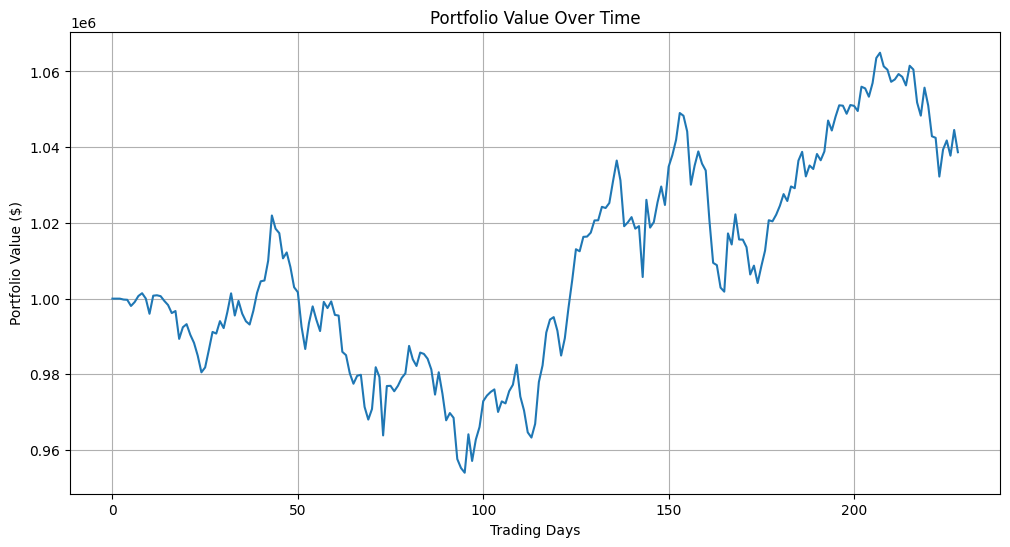


Performance Summary:
Initial portfolio value: ₹1000000.00
Final portfolio value: ₹1038676.09
Profit/Loss: ₹38676.09
ROI: 3.87%

Comparison with Buy & Hold strategy:
RELIANCE.NS: 5.96%
TCS.NS: -13.52%
HDFCBANK.NS: 8.39%
INFY.NS: -18.84%
SBIN.NS: 32.39%
ICICIBANK.NS: 17.20%
HINDUNILVR.NS: 10.15%
BHARTIARTL.NS: 17.12%
KOTAKBANK.NS: 0.21%
LT.NS: 9.86%
Average Buy & Hold return: 6.89%
Algorithm outperformance: -3.03%


In [ ]:
def run_complete_trading_system(stock_list, training_period, testing_period, algorithm='a2c'):
    """
    Run a complete trading system with all enhancements
    """
    print("Starting trading system with all enhancements...")
    print(f"Stocks: {stock_list}")
    print(f"Training period: {training_period[0]} to {training_period[1]}")
    print(f"Testing period: {testing_period[0]} to {testing_period[1]}")
    print(f"Algorithm: {algorithm.upper()}")

    # def add_technical_indicators(df):
    #   if df is None or df.empty:
    #     return None

    # # Make a copy to avoid modifying the original dataframe
    #   df_with_indicators = df.copy()

    #   # Debug the data structure
    #   print(f"DataFrame shape: {df.shape}")
    #   print(f"Close data type: {type(df['Close'])}")

    # # Helper function to ensure we have proper 1D pandas Series
    #   def ensure_series(data, name):
    #     if isinstance(data, pd.Series):
    #         # If it's already a proper series, return it
    #         if len(data.shape) == 1:
    #             return data
    #         else:
    #             # Convert multi-dimensional Series to 1D
    #             return pd.Series(data.values.flatten(), index=data.index, name=name)
    #     else:
    #         # Convert non-Series data to Series
    #         return pd.Series(data, name=name)

    # # Ensure all inputs are proper 1D pandas Series
    #     close = ensure_series(df['Close'], 'Close')
    #     high = ensure_series(df['High'], 'High')
    #     low = ensure_series(df['Low'], 'Low')
    #     volume = ensure_series(df['Volume'], 'Volume')

    # # Print shapes for debugging
    #     print(f"Processed Close shape: {close.shape}, dtype: {close.dtype}")

    #     try:
    #     # Add trend indicators - one at a time for better error tracking
    #       print("Adding SMA_20...")
    #       df_with_indicators['SMA_20'] = ta.trend.sma_indicator(close, window=20)

    #       print("Adding SMA_50...")
    #       df_with_indicators['SMA_50'] = ta.trend.sma_indicator(close, window=50)

    #       print("Adding EMA_20...")
    #       df_with_indicators['EMA_20'] = ta.trend.ema_indicator(close, window=20)

    #     # MACD
    #       print("Adding MACD...")
    #       macd = ta.trend.MACD(close)
    #       df_with_indicators['MACD_line'] = macd.macd()
    #       df_with_indicators['MACD_signal'] = macd.macd_signal()
    #       df_with_indicators['MACD_hist'] = macd.macd_diff()

    #     # Add momentum indicators
    #     # RSI
    #       print("Adding RSI...")
    #       df_with_indicators['RSI'] = ta.momentum.rsi(close, window=14)

    #     # Stochastic Oscillator
    #       print("Adding Stochastic Oscillator...")
    #       stoch = ta.momentum.StochasticOscillator(high, low, close)
    #       df_with_indicators['Stoch_k'] = stoch.stoch()
    #       df_with_indicators['Stoch_d'] = stoch.stoch_signal()

    #     # Add volatility indicators
    #     # Bollinger Bands
    #       print("Adding Bollinger Bands...")
    #       bollinger = ta.volatility.BollingerBands(close)
    #       df_with_indicators['BB_high'] = bollinger.bollinger_hband()
    #       df_with_indicators['BB_mid'] = bollinger.bollinger_mavg()
    #       df_with_indicators['BB_low'] = bollinger.bollinger_lband()
    #       df_with_indicators['BB_width'] = bollinger.bollinger_wband()

    #     # ATR (Average True Range)
    #       print("Adding ATR...")
    #       df_with_indicators['ATR'] = ta.volatility.average_true_range(high, low, close, window=14)

    #     # Add volume indicators
    #     # Volume moving average
    #       print("Adding Volume SMA...")
    #       df_with_indicators['Volume_SMA'] = ta.trend.sma_indicator(volume, window=20)

    #     # On-Balance Volume (OBV)
    #       print("Adding OBV...")
    #       df_with_indicators['OBV'] = ta.volume.on_balance_volume(close, volume)

    #     # Fill NaN values created by indicators that need a window of data
    #       df_with_indicators.fillna(method='bfill', inplace=True)

    #     except Exception as e:
    #       print(f"Error adding indicators: {e}")
    #       # If we hit an error, try a direct approach with NumPy conversion
    #       try:
    #         print("Falling back to manual calculation...")
    #         # Convert to numpy arrays
    #         close_np = close.values
    #         high_np = high.values
    #         low_np = low.values
    #         volume_np = volume.values

    #         # Calculate SMA manually
    #         def calculate_sma(data, window):
    #             return np.convolve(data, np.ones(window)/window, mode='valid')

    #         # Manually calculate indicators
    #         sma20 = calculate_sma(close_np, 20)
    #         sma50 = calculate_sma(close_np, 50)

    #         # Pad with NaN for the missing values at the beginning
    #         sma20_padded = np.concatenate([np.full(19, np.nan), sma20])
    #         sma50_padded = np.concatenate([np.full(49, np.nan), sma50])

    #         # Add back to dataframe
    #         df_with_indicators['SMA_20'] = sma20_padded[:len(df)]
    #         df_with_indicators['SMA_50'] = sma50_padded[:len(df)]

    #         # Fill NaN values
    #         df_with_indicators.fillna(method='bfill', inplace=True)

    #       except Exception as e2:
    #         print(f"Fallback also failed: {e2}")
    #         # Return original data if all else fails
    #         return df

    #     return df_with_indicators

    def preprocess_data(df):
      if df is None or df.empty:
        return None

    # Make a copy to avoid modifying the original dataframe
      df_processed = df.copy()

    # Handle missing values
      df_processed.dropna(inplace=True)

    # Add percentage change features
      df_processed['Returns'] = df_processed['Close'].pct_change()
      df_processed['Volume_Change'] = df_processed['Volume'].pct_change()

    # Volatility feature
      df_processed['Daily_Volatility'] = df_processed['Returns'].rolling(window=20).std()

    # Price distance from moving averages
      df_processed['Price_to_SMA20'] = df_processed['Close'] / df_processed['SMA_20'] - 1
      df_processed['Price_to_SMA50'] = df_processed['Close'] / df_processed['SMA_50'] - 1

    # Fill NaN values created by percentage change and rolling operations
      df_processed.fillna(method='bfill', inplace=True)

      return df_processed

    # Convert string dates to datetime objects for consistent comparison
    training_start = pd.to_datetime(training_period[0])
    training_end = pd.to_datetime(training_period[1])
    testing_start = pd.to_datetime(testing_period[0])
    testing_end = pd.to_datetime(testing_period[1])

    # 1. Fetch and process data
    stock_dfs = {}
    for ticker in stock_list:
        print(f"Processing {ticker}...")
        df = fetch_stock_data(ticker, training_period[0], testing_period[1])
        if df is not None:
            # Use the simpler indicators function
            df_processed = add_simple_indicators(df)
            if df_processed is not None:
                stock_dfs[ticker] = df_processed
            else:
                print(f"Failed to process indicators for {ticker}, skipping")
        else:
            print(f"No data for {ticker}, skipping")

    if not stock_dfs:
        print("No valid stock data found. Exiting.")
        return None

    # Split into training and testing data
    training_dfs = {}
    testing_dfs = {}

    for ticker, df in stock_dfs.items():
        try:
            # More robust date filtering using datetime objects and between
            mask_train = (df.index >= training_start) & (df.index <= training_end)
            mask_test = (df.index >= testing_start) & (df.index <= testing_end)

            training_dfs[ticker] = df.loc[mask_train].copy()
            testing_dfs[ticker] = df.loc[mask_test].copy()

            print(f"Training data for {ticker}: {len(training_dfs[ticker])} rows")
            print(f"Testing data for {ticker}: {len(testing_dfs[ticker])} rows")

            if training_dfs[ticker].empty or testing_dfs[ticker].empty:
                print(f"Warning: Empty data for {ticker} after filtering")
                print(f"Date range in data: {df.index.min()} to {df.index.max()}")

        except Exception as e:
            print(f"Error splitting data for {ticker}: {e}")
            print(f"Date range in data: {df.index.min()} to {df.index.max()}")
            print(f"Date types - Data index: {type(df.index[0])}, Training start: {type(training_start)}")
            continue

    # Check if we have valid data after filtering
    if not any(len(df) > 0 for df in training_dfs.values()) or not any(len(df) > 0 for df in testing_dfs.values()):
        print("No valid data after date filtering. Exiting.")
        return None

    # 2. Create risk-managed environment with sentiment analysis
    # First create base environment
    base_env_class = MultiStockTradingEnv

    # Add sentiment analysis
    sentiment_env_class = SentimentEnhancedTradingEnv.enhance_environment(base_env_class)

    # Create sentiment environment
    sentiment_env = sentiment_env_class(stock_dfs=training_dfs)

    # Add risk management
    risk_manager = RiskManager(max_position_size=0.3, stop_loss_pct=0.2, max_drawdown=0.2)
    risk_env = risk_manager.integrate_with_trading_env(sentiment_env, training_dfs)

    # Reset the environment to get the actual observation shape
    initial_observation = risk_env.reset()
    print(f"Actual observation shape: {initial_observation.shape}")

    # 3. Create and train agent based on selected algorithm and ACTUAL state dimensions
    # Get state and action dimensions from the environment
    state_size = initial_observation.shape  # Use actual observation shape
    action_size = risk_env.action_space.n

    actual_state_size = risk_env.observation_space.shape # Get shape from the attribute
    print(f"Using state_size for agent (from env.observation_space): {actual_state_size}") # Verify this is now (20, 67)
    assert all(isinstance(d, int) for d in actual_state_size), "State size dimensions must be concrete integers"
    # --- END Simplification ---

    # 3. Create Agent using the CORRECT state size from the attribute
    print(f"Creating {algorithm.upper()} agent with state_size={actual_state_size}, action_size={risk_env.action_space.n}")

    # Make sure state_size is passed correctly to the chosen agent
    if algorithm.lower() == 'dqn':
        agent = DQNAgent(state_size=actual_state_size, action_size=risk_env.action_space.n)
        train_fn = lambda env, agent: train_dqn_agent(env, agent, episodes=45)
    elif algorithm.lower() == 'a2c':
        agent = A2CAgent(state_size=actual_state_size, action_size=risk_env.action_space.n) # Pass correct size
        train_fn = train_a2c_agent
    else: # default to PPO
        agent = PPOAgent(state_size=actual_state_size, action_size=risk_env.action_space.n) # Pass correct size
        train_fn = train_ppo_agent

    # Make sure train_fn uses the correct final environment
    training_results = train_fn(risk_env, agent)

    # Create test environment
    test_risk_env = risk_manager.integrate_with_trading_env(
        SentimentEnhancedTradingEnv.enhance_environment(MultiStockTradingEnv)(stock_dfs=testing_dfs),
        testing_dfs
    )

    # Run test
    state = test_risk_env.reset()
    done = False
    total_reward = 0

    while not done:
        if hasattr(agent, 'act'):
            if isinstance(agent, (PPOAgent, A2CAgent)):
                action, _ = agent.act(state)
            else:
                action = agent.act(state)
        else:
            action = agent.select_action(state)

        next_state, reward, done, info = test_risk_env.step(action)
        state = next_state
        total_reward += reward

    # 5. Visualize and analyze results
    test_risk_env.render()

    # Performance metrics
    initial_value = test_risk_env.initial_balance
    final_value = test_risk_env.portfolio_value
    profit = final_value - initial_value
    roi = profit / initial_value * 100

    print(f"\nPerformance Summary:")
    print(f"Initial portfolio value: ₹{initial_value:.2f}")
    print(f"Final portfolio value: ₹{final_value:.2f}")
    print(f"Profit/Loss: ₹{profit:.2f}")
    print(f"ROI: {roi:.2f}%")

    # Compare with buy & hold for each stock
    print("\nComparison with Buy & Hold strategy:")
    for ticker in stock_list:
        first_price = testing_dfs[ticker].iloc[0]['Close']
        last_price = testing_dfs[ticker].iloc[-1]['Close']
        bh_return = (last_price - first_price) / first_price * 100
        print(f"{ticker}: {bh_return:.2f}%")

    # Average buy & hold return
    avg_bh_return = sum(
        (testing_dfs[ticker].iloc[-1]['Close'] - testing_dfs[ticker].iloc[0]['Close'])
        / testing_dfs[ticker].iloc[0]['Close']
        for ticker in stock_list
    ) / len(stock_list) * 100

    print(f"Average Buy & Hold return: {avg_bh_return:.2f}%")
    print(f"Algorithm outperformance: {roi - avg_bh_return:.2f}%")

    return {
        'agent': agent,
        'env': test_risk_env,
        'initial_value': initial_value,
        'final_value': final_value,
        'roi': roi,
        'buy_hold_roi': avg_bh_return
    }

# Example usage
if __name__ == '__main__':
    # Define stocks to trade (Indian stocks)
    stocks = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'SBIN.NS',
          'ICICIBANK.NS', 'HINDUNILVR.NS', 'BHARTIARTL.NS', 'KOTAKBANK.NS', 'LT.NS']

    # Define time periods
    training_period = ("2018-01-01", "2022-01-01")
    testing_period = ("2022-01-02", "2022-12-31")

    # Run the complete system
    results = run_complete_trading_system(
        stocks,
        training_period,
        testing_period,
        algorithm='a2c'  # Options: 'dqn', 'a2c', 'ppo'
    )

In [ ]:
import os
from datetime import datetime
import json

# Create directory for saved models
os.makedirs('saved_models', exist_ok=True)

# Check if results dictionary contains the agent
agent_found = False

if 'results' in locals() and isinstance(results, dict):
    print("Found results dictionary with keys:", list(results.keys()))

    # Try common keys where the agent might be stored
    potential_keys = ['agent', 'model', 'trained_agent', 'a2c_agent']

    for key in potential_keys:
        if key in results:
            try:
                if isinstance(results[key], A2CAgent):
                    print(f"Found A2C agent in results['{key}']")
                    agent = results[key]
                    agent_found = True
                    break
            except:
                continue

    # If not found in common keys, try all keys
    if not agent_found:
        for key in results:
            try:
                if isinstance(results[key], A2CAgent):
                    print(f"Found A2C agent in results['{key}']")
                    agent = results[key]
                    agent_found = True
                    break
            except:
                continue

# If still not found, search in global variables
if not agent_found:
    for var_name in dir():
        if var_name != 'A2CAgent' and 'agent' in var_name.lower():
            try:
                if isinstance(eval(var_name), A2CAgent):
                    print(f"Found A2C agent in variable: {var_name}")
                    agent = eval(var_name)
                    agent_found = True
                    break
            except:
                continue

# If still not found, show available variables and ask for manual input
if not agent_found:
    print("Could not automatically find the agent variable.")
    print("Available variables:")
    for var in dir():
        if not var.startswith('_') and var not in ['In', 'Out']:
            try:
                var_type = type(eval(var)).__name__
                print(f"  - {var}: {var_type}")
            except:
                pass

    # Print contents of results if it exists
    if 'results' in locals() and isinstance(results, dict):
        print("\nContents of results dictionary:")
        for key, value in results.items():
            print(f"  - {key}: {type(value).__name__}")

    # Manual input options
    print("\nOptions:")
    print("1. Enter variable name directly")
    print("2. Enter results dictionary key")
    choice = input("Enter choice (1 or 2): ")

    if choice == "1":
        agent_var_name = input("Please enter the name of your agent variable: ")
        try:
            agent = eval(agent_var_name)
            agent_found = True
        except:
            print(f"Error: Could not evaluate {agent_var_name}")
    elif choice == "2":
        key_name = input("Please enter the key in results dictionary: ")
        try:
            agent = results[key_name]
            agent_found = True
        except:
            print(f"Error: Could not access results['{key_name}']")
    else:
        print("Invalid choice")

if agent_found:
    # Generate timestamp for the model name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"a2c_trading_model_{timestamp}"

    # Create directory if it doesn't exist
    save_dir = 'saved_models'
    os.makedirs(save_dir, exist_ok=True)

    # Save actor model with correct extension
    actor_path = os.path.join(save_dir, f"{model_name}_actor.weights.h5")
    agent.actor.save_weights(actor_path)
    print(f"Actor network saved to: {actor_path}")

    # Save critic model with correct extension
    critic_path = os.path.join(save_dir, f"{model_name}_critic.weights.h5")
    agent.critic.save_weights(critic_path)
    print(f"Critic network saved to: {critic_path}")

    # Save metadata about the model
    metadata_path = os.path.join(save_dir, f"{model_name}_metadata.json")
    metadata = {
        "model_type": "A2C",
        "saved_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "state_size": str(agent.state_size),
        "action_size": agent.action_size,
        "actor_lr": agent.actor_lr,
        "critic_lr": agent.critic_lr,
        "gamma": agent.gamma
    }

    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)

    print(f"Model metadata saved to: {metadata_path}")
    print(f"Model saved successfully with name: {model_name}")
else:
    print("Could not save the model because no agent variable was found or specified.")


Found results dictionary with keys: ['agent', 'env', 'initial_value', 'final_value', 'roi', 'buy_hold_roi']
Found A2C agent in results['agent']
Actor network saved to: saved_models/a2c_trading_model_20250514_081408_actor.weights.h5
Critic network saved to: saved_models/a2c_trading_model_20250514_081408_critic.weights.h5
Model metadata saved to: saved_models/a2c_trading_model_20250514_081408_metadata.json
Model saved successfully with name: a2c_trading_model_20250514_081408


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import time
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Model, load_model

def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock data using yfinance with delay between requests
    to avoid rate limiting
    """
    try:
        print(f"Fetching data for {ticker} from {start_date} to {end_date}")
        # Add delay to avoid rate limiting
        time.sleep(2)

        stock_data = yf.download(ticker, start=start_date, end=end_date)

        if stock_data.empty:
            print(f"No data found for {ticker}.")
            return None

        # Ensure index is datetime
        stock_data.index = pd.to_datetime(stock_data.index)

        # Check if we have a MultiIndex structure
        if isinstance(stock_data.columns, pd.MultiIndex):
            print(f"MultiIndex detected for {ticker}, flattening...")

            # Create a new dataframe with flattened columns
            flattened_df = pd.DataFrame(index=stock_data.index)

            # Extract each column we need
            if ('Close', ticker) in stock_data.columns:
                flattened_df['Close'] = stock_data[('Close', ticker)]
                flattened_df['Open'] = stock_data[('Open', ticker)]
                flattened_df['High'] = stock_data[('High', ticker)]
                flattened_df['Low'] = stock_data[('Low', ticker)]
                flattened_df['Volume'] = stock_data[('Volume', ticker)]
            else:
                # Try to find the columns regardless of their exact structure
                for col in stock_data.columns:
                    if col[0] == 'Close':
                        flattened_df['Close'] = stock_data[col]
                    elif col[0] == 'Open':
                        flattened_df['Open'] = stock_data[col]
                    elif col[0] == 'High':
                        flattened_df['High'] = stock_data[col]
                    elif col[0] == 'Low':
                        flattened_df['Low'] = stock_data[col]
                    elif col[0] == 'Volume':
                        flattened_df['Volume'] = stock_data[col]

            return flattened_df
        else:
            # If not MultiIndex, return as is
            return stock_data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

def add_simple_indicators(df):
    """
    Add technical indicators to stock data, handling MultiIndex structure
    """
    if df is None or df.empty:
        return None

    result = df.copy()

    try:
        # Check if we have a MultiIndex structure
        if isinstance(result.columns, pd.MultiIndex):
            # Extract just the 'Close' column
            close_series = result[('Close', result.columns.levels[1][0])]
            open_series = result[('Open', result.columns.levels[1][0])]
            high_series = result[('High', result.columns.levels[1][0])]
            low_series = result[('Low', result.columns.levels[1][0])]
            volume_series = result[('Volume', result.columns.levels[1][0])]

            # Create a new DataFrame with flattened columns
            result = pd.DataFrame(index=df.index)
            result['Close'] = close_series
            result['Open'] = open_series
            result['High'] = high_series
            result['Low'] = low_series
            result['Volume'] = volume_series

        # Now calculate indicators on the flattened DataFrame
        result['SMA_20'] = result['Close'].rolling(window=20).mean()
        result['SMA_50'] = result['Close'].rolling(window=50).mean()

        # Calculate price to moving average ratios
        result['Price_to_SMA20'] = result['Close'] / result['SMA_20']
        result['Price_to_SMA50'] = result['Close'] / result['SMA_50']

        # Daily returns
        result['Daily_Return'] = result['Close'].pct_change()

        # Volatility (20-day standard deviation of returns)
        result['Volatility'] = result['Daily_Return'].rolling(window=20).std()

        # RSI (14-day)
        delta = result['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        result['RSI'] = 100 - (100 / (1 + rs))

        # MACD
        ema12 = result['Close'].ewm(span=12, adjust=False).mean()
        ema26 = result['Close'].ewm(span=26, adjust=False).mean()
        result['MACD'] = ema12 - ema26
        result['MACD_Signal'] = result['MACD'].ewm(span=9, adjust=False).mean()

        # Fill missing values
        result.fillna(method='bfill', inplace=True)

        return result
    except Exception as e:
        print(f"Error adding indicators: {e}")
        return None

class A2CAgent:
    """
    A2C Agent for trading
    """
    def __init__(self, state_size, action_size, actor_lr=0.0002, critic_lr=0.0004, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr

        # Build actor and critic networks
        self.actor = None
        self.critic = None

    def act(self, state):
        """Choose action based on actor network"""
        state_reshaped = np.reshape(state, (1,) + self.state_size)

        # Handle potential shape mismatch
        if state_reshaped.size != np.prod((1,) + self.state_size):
            print(f"Warning: State shape mismatch. Expected {(1,) + self.state_size}, got {state_reshaped.shape}")
            # Reshape or pad/truncate the state to match expected dimensions
            flattened = state_reshaped.flatten()
            target_size = np.prod((1,) + self.state_size)

            if flattened.size > target_size:
                # Truncate if too large
                flattened = flattened[:target_size]
            elif flattened.size < target_size:
                # Pad with zeros if too small
                padding = np.zeros(target_size - flattened.size)
                flattened = np.concatenate([flattened, padding])

            # Reshape to expected dimensions
            state_reshaped = flattened.reshape((1,) + self.state_size)

        action_probs_raw = self.actor.predict(state_reshaped, verbose=0)
        action_probs = np.squeeze(action_probs_raw[0])
        action_probs = np.clip(action_probs, 1e-8, 1.0)
        action_probs /= np.sum(action_probs)

        try:
            action = np.random.choice(self.action_size, p=action_probs)
        except ValueError as e:
            print(f"Error in np.random.choice: {e}")
            action = np.argmax(action_probs)

        return action, action_probs

def load_a2c_model(state_size, action_size, actor_path, critic_path):
    """
    Load a saved A2C model from disk
    """
    # Create a new agent with the specified state and action sizes
    agent = A2CAgent(state_size=state_size, action_size=action_size)

    # Build the actor and critic models
    agent.actor = agent._build_actor()
    agent.critic = agent._build_critic()

    # Load the saved weights
    agent.actor.load_weights(actor_path)
    agent.critic.load_weights(critic_path)

    print(f"Model loaded successfully from {actor_path} and {critic_path}")

    return agent

def run_backtest(env, agent):
    """
    Backtest an agent on the given environment

    Args:
        env: Trading environment
        agent: Trained agent

    Returns:
        Dictionary with backtest results
    """
    print("Running backtest...")
    state = env.reset()
    done = False
    total_reward = 0
    portfolio_values = [env.portfolio_value]
    actions_taken = []
    dates = []

    # Store initial date
    if hasattr(env, 'current_date'):
        dates.append(env.current_date)

    # Run until episode is done
    step_count = 0
    while not done:
        step_count += 1

        # Get action from agent
        try:
            action, action_probs = agent.act(state)
            actions_taken.append(action)

            # Take step in environment
            next_state, reward, done, info = env.step(action)

            # Store date if available
            if 'date' in info and info['date'] is not None:
                dates.append(info['date'])

            # Update state and tracking variables
            state = next_state
            total_reward += reward
            portfolio_values.append(info['portfolio_value'])

            # Print progress periodically
            if step_count % 50 == 0:
                current_date = info['date'] if 'date' in info else 'Unknown'
                print(f"Step: {step_count}, Date: {current_date}, Portfolio Value: {info['portfolio_value']:.2f}")

        except Exception as e:
            print(f"Error during backtest step {step_count}: {e}")
            import traceback
            traceback.print_exc()
            done = True

    # Calculate returns and other metrics
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    total_return = (final_value / initial_value - 1) * 100

    # Calculate drawdown
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = np.max(drawdown) * 100

    # Calculate Sharpe ratio
    if len(portfolio_values) > 1:
        returns = np.diff(np.log(portfolio_values))
        sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Annualized
    else:
        sharpe = 0

    print(f"Backtest completed:")
    print(f"Initial Portfolio Value: {initial_value:.2f}")
    print(f"Final Portfolio Value: {final_value:.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.4f}")

    # Return results
    results = {
        'initial_value': initial_value,
        'final_value': final_value,
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe,
        'portfolio_values': portfolio_values,
        'total_reward': total_reward,
        'actions': actions_taken,
        'dates': dates
    }

    # Plot results
    if len(dates) == len(portfolio_values):
        plt.figure(figsize=(12, 6))
        plt.plot(dates, portfolio_values)
        plt.title('Portfolio Value During Backtest')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value ($)')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return results

def batch_download_stock_data(tickers, start_date, end_date):
    """
    Download data for all tickers at once to avoid rate limiting
    """
    print(f"Batch downloading data for {len(tickers)} stocks...")
    try:
        # Download all stocks at once
        data = yf.download(tickers, start=start_date, end=end_date)

        # Process the multi-level dataframe
        stock_dfs = {}
        for ticker in tickers:
            try:
                # Extract data for this ticker
                if len(tickers) > 1:
                    ticker_data = data.xs(ticker, level=1, axis=1).copy()
                else:
                    ticker_data = data.copy()

                if not ticker_data.empty:
                    processed_data = add_simple_indicators(ticker_data)
                    if processed_data is not None:
                        stock_dfs[ticker] = processed_data
                        print(f"Loaded data for {ticker}: {len(processed_data)} rows")
            except Exception as e:
                print(f"Error processing {ticker} from batch data: {e}")

        return stock_dfs
    except Exception as e:
        print(f"Error in batch download: {e}")
        return {}

def load_and_backtest_a2c_model(actor_path, critic_path, tickers, start_date, end_date, initial_balance=1000000, transaction_fee=0.001):
    """Load a saved A2C model and run a backtest"""
    print(f"Loading model and running backtest from {start_date} to {end_date}")
    print(f"Tickers: {tickers}")

    # Extract state_size and action_size from the model metadata
    model_dir = os.path.dirname(actor_path)
    metadata_path = actor_path.replace('_actor.weights.h5', '_metadata.json')

    try:
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
            original_state_size = eval(metadata['state_size'])  # Convert string representation to tuple
            original_action_size = metadata['action_size']
            print(f"Original model state_size: {original_state_size}, action_size: {original_action_size}")
    except Exception as e:
        print(f"Error loading metadata: {e}. Using default sizes.")
        original_state_size = (20, 132)  # Default based on your error message
        original_action_size = 91

    # Fetch data for all tickers
    stock_dfs = {}
    for ticker in tickers:
        df = fetch_stock_data(ticker, start_date, end_date)
        if df is not None:
            processed_data = add_simple_indicators(df)
            if processed_data is not None:
                stock_dfs[ticker] = processed_data
                print(f"Loaded data for {ticker}: {len(processed_data)} rows")
        else:
            print(f"No data for {ticker}, skipping")

    if not stock_dfs:
        print("No valid stock data found. Exiting.")
        return None

    # Create base environment
    base_env = MultiStockTradingEnv(
        stock_dfs=stock_dfs,
        initial_balance=initial_balance,
        transaction_fee_percent=transaction_fee,
        window_size=original_state_size[0]
    )

    # Apply the same sentiment enhancement that was used during training
    SentimentEnhancedEnv = SentimentEnhancedTradingEnv.enhance_environment(MultiStockTradingEnv)
    env = SentimentEnhancedEnv(
        stock_dfs=stock_dfs,
        initial_balance=initial_balance,
        transaction_fee_percent=transaction_fee,
        window_size=original_state_size[0]
    )

    # Create agent with the original dimensions from training
    agent = A2CAgent(state_size=original_state_size, action_size=original_action_size)

    agent.actor = agent._build_actor()
    agent.critic = agent._build_critic()

    # Load the saved weights
    agent.actor.load_weights(actor_path)
    agent.critic.load_weights(critic_path)

    print(f"Model loaded successfully")

    # Run backtest
    results = run_backtest(env, agent)

    return results

def run_backtest(env, agent):
    """
    Backtest an agent on the given environment
    """
    print("Running backtest...")
    state = env.reset()
    done = False
    total_reward = 0
    portfolio_values = [env.portfolio_value]
    actions_taken = []
    dates = []

    # Store initial date
    if hasattr(env, 'current_date'):
        dates.append(env.current_date)

    # Run until episode is done
    step_count = 0
    while not done:
        step_count += 1

        # Get action from agent
        try:
            # Ensure state shape matches what the model expects
            if state.shape != agent.state_size and state.size != np.prod(agent.state_size):
                print(f"Warning: State shape mismatch. Got {state.shape}, expected {agent.state_size}")

                # Reshape or resize to match expected dimensions
                if state.size > np.prod(agent.state_size):
                    # If too large, flatten and truncate
                    flattened = state.flatten()[:np.prod(agent.state_size)]
                    state = flattened.reshape(agent.state_size)
                else:
                    # If too small, flatten and pad with zeros
                    flattened = state.flatten()
                    padding = np.zeros(np.prod(agent.state_size) - state.size)
                    padded = np.concatenate([flattened, padding])
                    state = padded.reshape(agent.state_size)

            action, action_probs = agent.act(state)
            actions_taken.append(action)

            # Take step in environment
            next_state, reward, done, info = env.step(action)

            # Store date if available
            if 'date' in info and info['date'] is not None:
                dates.append(info['date'])

            # Update state and tracking variables
            state = next_state
            total_reward += reward
            portfolio_values.append(info['portfolio_value'])

            # Print progress periodically
            if step_count % 50 == 0:
                current_date = info['date'] if 'date' in info else 'Unknown'
                print(f"Step: {step_count}, Date: {current_date}, Portfolio Value: {info['portfolio_value']:.2f}")

        except Exception as e:
            print(f"Error during backtest step {step_count}: {e}")
            import traceback
            traceback.print_exc()
            done = True

    # Calculate returns and other metrics
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    total_return = (final_value / initial_value - 1) * 100

    # Calculate drawdown
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = np.max(drawdown) * 100

    # Calculate Sharpe ratio
    if len(portfolio_values) > 1:
        returns = np.diff(np.log(portfolio_values))
        sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Annualized
    else:
        sharpe = 0

    print(f"Backtest completed:")
    print(f"Initial Portfolio Value: {initial_value:.2f}")
    print(f"Final Portfolio Value: {final_value:.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.4f}")

    # Return results
    results = {
        'initial_value': initial_value,
        'final_value': final_value,
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe,
        'portfolio_values': portfolio_values,
        'total_reward': total_reward,
        'actions': actions_taken,
        'dates': dates
    }

    return results

# Example usage
if __name__ == "__main__":
    # Define paths to your saved model weights
    actor_path = 'saved_models/a2c_trading_model_20250514_081408_actor.weights.h5'
    critic_path = 'saved_models/a2c_trading_model_20250514_081408_critic.weights.h5'

    # Define tickers and date range for backtesting
    tickers = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'SBIN.NS',
              'ICICIBANK.NS', 'HINDUNILVR.NS', 'BHARTIARTL.NS', 'KOTAKBANK.NS', 'LT.NS']

    start_date = '2022-01-01'
    end_date = '2022-12-31'

    # Load model and run backtest
    results = load_and_backtest_a2c_model(
        actor_path=actor_path,
        critic_path=critic_path,
        tickers=tickers,
        start_date=start_date,
        end_date=end_date,
        initial_balance=1000000,
        transaction_fee=0.001
    )

    # Analyze results
    if results:
        # Plot portfolio value over time
        plt.figure(figsize=(14, 7))
        plt.plot(results['dates'], results['portfolio_values'])
        plt.title('Portfolio Value During Backtest')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value ($)')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('backtest_results.png')
        plt.show()

        # Save results to file
        with open('backtest_results.json', 'w') as f:
            # Convert numpy values to Python native types
            serializable_results = {
                'initial_value': float(results['initial_value']),
                'final_value': float(results['final_value']),
                'total_return': float(results['total_return']),
                'max_drawdown': float(results['max_drawdown']),
                'sharpe_ratio': float(results['sharpe_ratio']),
                'total_reward': float(results['total_reward']),
                'actions': [int(a) for a in results['actions']],
                'dates': [d.strftime('%Y-%m-%d') for d in results['dates']]
            }
            json.dump(serializable_results, f, indent=4)

Loading model and running backtest from 2022-01-01 to 2022-12-31
Tickers: ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'SBIN.NS', 'ICICIBANK.NS', 'HINDUNILVR.NS', 'BHARTIARTL.NS', 'KOTAKBANK.NS', 'LT.NS']
Original model state_size: (20, 132), action_size: 91
Fetching data for RELIANCE.NS from 2022-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for RELIANCE.NS, flattening...
Loaded data for RELIANCE.NS: 248 rows
Fetching data for TCS.NS from 2022-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for TCS.NS, flattening...
Loaded data for TCS.NS: 248 rows
Fetching data for HDFCBANK.NS from 2022-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for HDFCBANK.NS, flattening...
Loaded data for HDFCBANK.NS: 248 rows
Fetching data for INFY.NS from 2022-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for INFY.NS, flattening...
Loaded data for INFY.NS: 248 rows
Fetching data for SBIN.NS from 2022-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for SBIN.NS, flattening...
Loaded data for SBIN.NS: 248 rows
Fetching data for ICICIBANK.NS from 2022-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for ICICIBANK.NS, flattening...
Loaded data for ICICIBANK.NS: 248 rows
Fetching data for HINDUNILVR.NS from 2022-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for HINDUNILVR.NS, flattening...
Loaded data for HINDUNILVR.NS: 248 rows
Fetching data for BHARTIARTL.NS from 2022-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for BHARTIARTL.NS, flattening...
Loaded data for BHARTIARTL.NS: 248 rows
Fetching data for KOTAKBANK.NS from 2022-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for KOTAKBANK.NS, flattening...
Loaded data for KOTAKBANK.NS: 248 rows
Fetching data for LT.NS from 2022-01-01 to 2022-12-31


[*********************100%***********************]  1 of 1 completed


MultiIndex detected for LT.NS, flattening...
Loaded data for LT.NS: 248 rows
Trading environment created with 248 common trading days
Reset environment: current_date_idx=20, current_date=2022-02-01 00:00:00
Combined stock data shape: (20, 140)
Loading FinBERT model for sentiment analysis...
FinBERT model loaded successfully.
Calculating sentiment scores for each stock...
Processing sentiment for RELIANCE.NS: 0/248
Processing sentiment for RELIANCE.NS: 50/248
Processing sentiment for RELIANCE.NS: 100/248
Processing sentiment for RELIANCE.NS: 150/248
Processing sentiment for RELIANCE.NS: 200/248
Processing sentiment for TCS.NS: 0/248
Processing sentiment for TCS.NS: 50/248
Processing sentiment for TCS.NS: 100/248
Processing sentiment for TCS.NS: 150/248
Processing sentiment for TCS.NS: 200/248
Processing sentiment for HDFCBANK.NS: 0/248
Processing sentiment for HDFCBANK.NS: 50/248
Processing sentiment for HDFCBANK.NS: 100/248
Processing sentiment for HDFCBANK.NS: 150/248
Processing senti

AttributeError: 'A2CAgent' object has no attribute '_build_actor'